In [2]:
### Libraries
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit, StratifiedKFold, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
import os
import pickle
import matplotlib.pyplot as plt

In [2]:
# List of GitHub raw URLs
urls = [
    'https://raw.githubusercontent.com/JetendraMulinti/DAV-6150---DataScience/main/FinalProject-NBA_Prediction/Data/season_-2020.csv',
    'https://raw.githubusercontent.com/JetendraMulinti/DAV-6150---DataScience/main/FinalProject-NBA_Prediction/Data/season_-2021.csv',
    'https://raw.githubusercontent.com/JetendraMulinti/DAV-6150---DataScience/main/FinalProject-NBA_Prediction/Data/season_-2022.csv',
    'https://raw.githubusercontent.com/JetendraMulinti/DAV-6150---DataScience/main/FinalProject-NBA_Prediction/Data/season_-2023.csv'
]

all_cleaned_dataframes = []

for url in urls:
    try:
        # Load the dataframe from pickle data obtained from URL
        dataframe = pd.read_csv(url)
        
        # Filter out columns that start with 'Unnamed:'
        dataframe = dataframe.loc[:, ~dataframe.columns.str.startswith('Unnamed:')]

        # Drop all columns that are entirely NA
        dataframe = dataframe.dropna(axis=1, how='all')

        # Add the cleaned dataframe to the list
        all_cleaned_dataframes.append(dataframe)
        
        print(f"Processed data from {url}")

    except Exception as e:
        print(f"Error processing {url}: {e}")

# Concatenate all dataframes into one
df = pd.concat(all_cleaned_dataframes, ignore_index=True)


### delete some more columns
columns_to_delete = ['OT', 'OT_opp', '2OT', '3OT', '2OT_opp', '3OT_opp',
                     ## '4OT', '4OT_opp',
                    'mp_total_opp','bpm_max','bpm_max_opp']

# Drop the specified columns from the dataframe
df.drop(columns=columns_to_delete, inplace=True)


print("No of duplicate rows: ",df.duplicated().sum())

### Drop duplicates
df = df.drop_duplicates().reset_index(drop=True)

print("No of duplicate rows after dropping duplicates: ",df.duplicated().sum())

#### rename columns
df.rename(columns = {'mp_total':'mp'}, inplace=True)

#### Creating Season column
df['date'] = pd.to_datetime(df['date'])  # Convert 'date' column to datetime if it's not already

# Function to determine the season year based on the month
def get_season_year(row):
    if row['date'].month >= 10:
        return row['date'].year
    else:
        return row['date'].year - 1

# Apply the function to create a new 'season' column
df['season'] = df.apply(get_season_year, axis=1)


print("data shape:", df.shape)

columns_format = list(df.columns)

df.head(2)

Processed data from https://raw.githubusercontent.com/JetendraMulinti/DAV-6150---DataScience/main/FinalProject-NBA_Prediction/Data/season_-2020.csv
Processed data from https://raw.githubusercontent.com/JetendraMulinti/DAV-6150---DataScience/main/FinalProject-NBA_Prediction/Data/season_-2021.csv
Processed data from https://raw.githubusercontent.com/JetendraMulinti/DAV-6150---DataScience/main/FinalProject-NBA_Prediction/Data/season_-2022.csv
Processed data from https://raw.githubusercontent.com/JetendraMulinti/DAV-6150---DataScience/main/FinalProject-NBA_Prediction/Data/season_-2023.csv
No of duplicate rows:  0
No of duplicate rows after dropping duplicates:  0
data shape: (9896, 149)


,mp,fg_total,fga_total,fg%_total,3p_total,3pa_total,3p%_total,ft_total,fta_total,ft%_total,...,team_opp,1_opp,2_opp,3_opp,4_opp,total_opp,home_opp,date,won,season
0,265.0,43.0,102.0,0.422,19.0,45.0,0.422,17.0,20.0,0.850,...,TOR,27,29,32,29,130,1,2019-10-22,False,2019
1,265.0,42.0,103.0,0.408,14.0,40.0,0.350,32.0,38.0,0.842,...,NOP,30,31,25,31,122,0,2019-10-22,True,2019


## Data Cleaning

In [3]:
##### Abbrivate the Team names
team_df = pd.read_csv('https://raw.githubusercontent.com/JetendraMulinti/DAV-6150---DataScience/main/FinalProject-NBA_Prediction/Data/Team_full-forms.csv')
team_df['team'] = team_df['team'].str.strip()
team_df['team1'] = team_df['team1'].str.strip()


##### Merge and delete the columns
df = pd.merge(team_df, df, on = ['team'], how='inner')
del df['team']
df.rename(columns = {'team1':'team'}, inplace=True)

team_df.rename(columns = {'team':'team_opp'}, inplace=True)
df = pd.merge(team_df, df, on = ['team_opp'], how='inner')
del df['team_opp']
df.rename(columns = {'team1':'team_opp'}, inplace=True)

print("data shape:", df.shape)

df = df[columns_format]

## ordering with date
df['date'] = pd.to_datetime(df['date']).dt.date
df = df.sort_values(by = ['date'], ascending=True).reset_index(drop=True)

df.head()

data shape: (9896, 149)


,mp,fg_total,fga_total,fg%_total,3p_total,3pa_total,3p%_total,ft_total,fta_total,ft%_total,...,team_opp,1_opp,2_opp,3_opp,4_opp,total_opp,home_opp,date,won,season
0,240.0,42.0,81.0,0.519,11.0,31.0,0.355,17.0,24.0,0.708,...,Los Angeles Lakers,25,29,31,17,102,0,2019-10-22,True,2019
1,240.0,37.0,85.0,0.435,13.0,33.0,0.394,15.0,21.0,0.714,...,Los Angeles Clippers,22,40,23,27,112,1,2019-10-22,False,2019
2,265.0,42.0,103.0,0.408,14.0,40.0,0.350,32.0,38.0,0.842,...,New Orleans Pelicans,30,31,25,31,122,0,2019-10-22,True,2019
3,265.0,43.0,102.0,0.422,19.0,45.0,0.422,17.0,20.0,0.850,...,Toronto Raptors,27,29,32,29,130,1,2019-10-22,False,2019
4,240.0,35.0,76.0,0.461,11.0,36.0,0.306,27.0,33.0,0.818,...,Washington Wizards,25,23,20,32,100,0,2019-10-23,True,2019


In [4]:
df['season'].value_counts()

season
2021    2644
2022    2638
2020    2338
2019    2276
Name: count, dtype: int64

In [5]:
### checking the data is balance / Imbalanced

df['won'].value_counts()

won
True     4948
False    4948
Name: count, dtype: int64

Checking Null values and dropping columns and rows

In [6]:
### Checking null values

null_columns = df.isnull().sum()
null_columns[null_columns > 0]

+/-_max          15
index_opp      7620
+/-_max_opp      15
dtype: int64

In [7]:
### delete some more columns
more_columns_to_delete = ['index_opp']

# Drop the specified columns from the dataframe
df.drop(columns=more_columns_to_delete, inplace=True)

## as we have only 1 null row (match) we will drop it
df = df.dropna()

null_columns = df.isnull().sum()
null_columns[null_columns > 0]

Series([], dtype: int64)

In [8]:
## re-ordering on date

## ordering with date
df['date'] = pd.to_datetime(df['date']).dt.date
df = df.sort_values(by = ['date'], ascending=True).reset_index(drop=True)

print("data shape:", df.shape)


print("no of rows before: ", len(df))

#### Deleting the repeated rows (Instead of both perpestives)
# Create a sorted string that combines team names and game date
df['game_id'] = df.apply(lambda x: '_'.join(sorted([x['team'], x['team_opp']])) + '_' + str(x['date']), axis=1)

# Keep only one entry per game based on the alphabetical order of team names
df = df.sort_values(by=['team', 'team_opp']).drop_duplicates(subset='game_id', keep='first').reset_index(drop=True)

print("no of rows After: ", len(df))

df.head()

data shape: (9880, 148)
no of rows before:  9880
no of rows After:  4940


,mp,fg_total,fga_total,fg%_total,3p_total,3pa_total,3p%_total,ft_total,fta_total,ft%_total,...,1_opp,2_opp,3_opp,4_opp,total_opp,home_opp,date,won,season,game_id
0,240.0,39.0,93.0,0.419,16.0,45.0,0.356,12.0,15.0,0.800,...,19,34,29,27,109,1,2020-01-03,False,2019,Atlanta Hawks_Boston Celtics_2020-01-03
1,240.0,42.0,84.0,0.500,12.0,30.0,0.400,19.0,21.0,0.905,...,28,32,35,28,123,0,2020-02-03,False,2019,Atlanta Hawks_Boston Celtics_2020-02-03
2,240.0,35.0,86.0,0.407,13.0,39.0,0.333,24.0,26.0,0.923,...,28,26,33,25,112,1,2020-02-07,False,2019,Atlanta Hawks_Boston Celtics_2020-02-07
3,240.0,44.0,77.0,0.571,8.0,24.0,0.333,26.0,31.0,0.839,...,35,21,25,33,114,1,2021-02-17,True,2020,Atlanta Hawks_Boston Celtics_2021-02-17
4,240.0,38.0,90.0,0.422,10.0,30.0,0.333,23.0,25.0,0.920,...,33,33,32,23,121,1,2021-02-19,False,2020,Atlanta Hawks_Boston Celtics_2021-02-19


## Exploratory Data Analysis

In [9]:
# Generate descriptive statistics for key metrics
key_metrics = ['fg_total', 'fga_total', 'fg%_total', '3p_total', '3pa_total', '3p%_total', 'ft_total',
               'fta_total', 'ft%_total', 'total_opp', '+/-_max']

# Selecting the key metrics and generating descriptive statistics
key_stats_summary = df[key_metrics].describe()

# Display the descriptive statistics for key metrics
key_stats_summary

,fg_total,fga_total,fg%_total,3p_total,3pa_total,3p%_total,ft_total,fta_total,ft%_total,total_opp,+/-_max
count,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000
mean,41.065789,88.071457,0.467303,12.570648,34.825101,0.360107,17.516599,22.514980,0.778650,111.941903,13.451822
std,5.227050,6.985447,0.055901,3.942961,6.983840,0.085041,5.864323,7.060579,0.100366,12.493791,9.180685
min,21.000000,64.000000,0.269000,2.000000,10.000000,0.077000,3.000000,4.000000,0.308000,73.000000,-16.000000
25%,37.000000,83.000000,0.429000,10.000000,30.000000,0.303000,13.000000,17.000000,0.714000,103.000000,6.750000
50%,41.000000,88.000000,0.467000,12.000000,35.000000,0.357000,17.000000,22.000000,0.785000,112.000000,13.000000
75%,45.000000,93.000000,0.505000,15.000000,39.000000,0.417000,21.000000,27.000000,0.850000,120.000000,19.000000
max,60.000000,117.000000,0.687000,28.000000,61.000000,0.645000,40.000000,50.000000,1.000000,176.000000,52.000000


In [10]:
# Generate descriptive statistics for key metrics
key_metrics_opp = ['fg_total_opp', 'fga_total_opp', 'fg%_total_opp', '3p_total_opp', '3pa_total_opp', '3p%_total_opp', 'ft_total_opp',
               'fta_total_opp', 'ft%_total_opp', '+/-_max_opp']

# Selecting the key metrics and generating descriptive statistics
key_stats_summary_opp = df[key_metrics_opp].describe()

# Display the descriptive statistics for key metrics
key_stats_summary_opp

,fg_total_opp,fga_total_opp,fg%_total_opp,3p_total_opp,3pa_total_opp,3p%_total_opp,ft_total_opp,fta_total_opp,ft%_total_opp,+/-_max_opp
count,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000
mean,41.028947,88.350607,0.465373,12.270040,34.297773,0.356931,17.613968,22.664980,0.776921,13.097368
std,5.164060,7.065837,0.054333,3.834598,6.857692,0.084321,5.929307,7.091262,0.101620,9.063678
min,23.000000,63.000000,0.277000,2.000000,15.000000,0.091000,2.000000,2.000000,0.300000,-18.000000
25%,38.000000,84.000000,0.427000,10.000000,30.000000,0.300000,13.000000,18.000000,0.714000,6.000000
50%,41.000000,88.000000,0.464000,12.000000,34.000000,0.357000,17.000000,22.000000,0.783000,12.000000
75%,44.000000,93.000000,0.505000,15.000000,39.000000,0.414000,22.000000,27.000000,0.846000,19.000000
max,65.000000,121.000000,0.674000,29.000000,63.000000,0.684000,43.000000,52.000000,1.000000,54.000000


1. Field Goals Made and Attempted (fg_total, fga_total): Teams make an average of 40 field goals per game from 87 attempts, translating to an average field goal percentage of 46.2%.
2. Three-Point Shots (3p_total, 3pa_total, 3p%_total): On average, teams successfully make 11 three-point shots per game from 31 attempts, achieving a three-point shooting percentage of 35.7%.
3. Free Throws (ft_total, fta_total, ft%_total): Teams typically make 17 free throws per game from 23 attempts, with an average success rate of 77.2%.

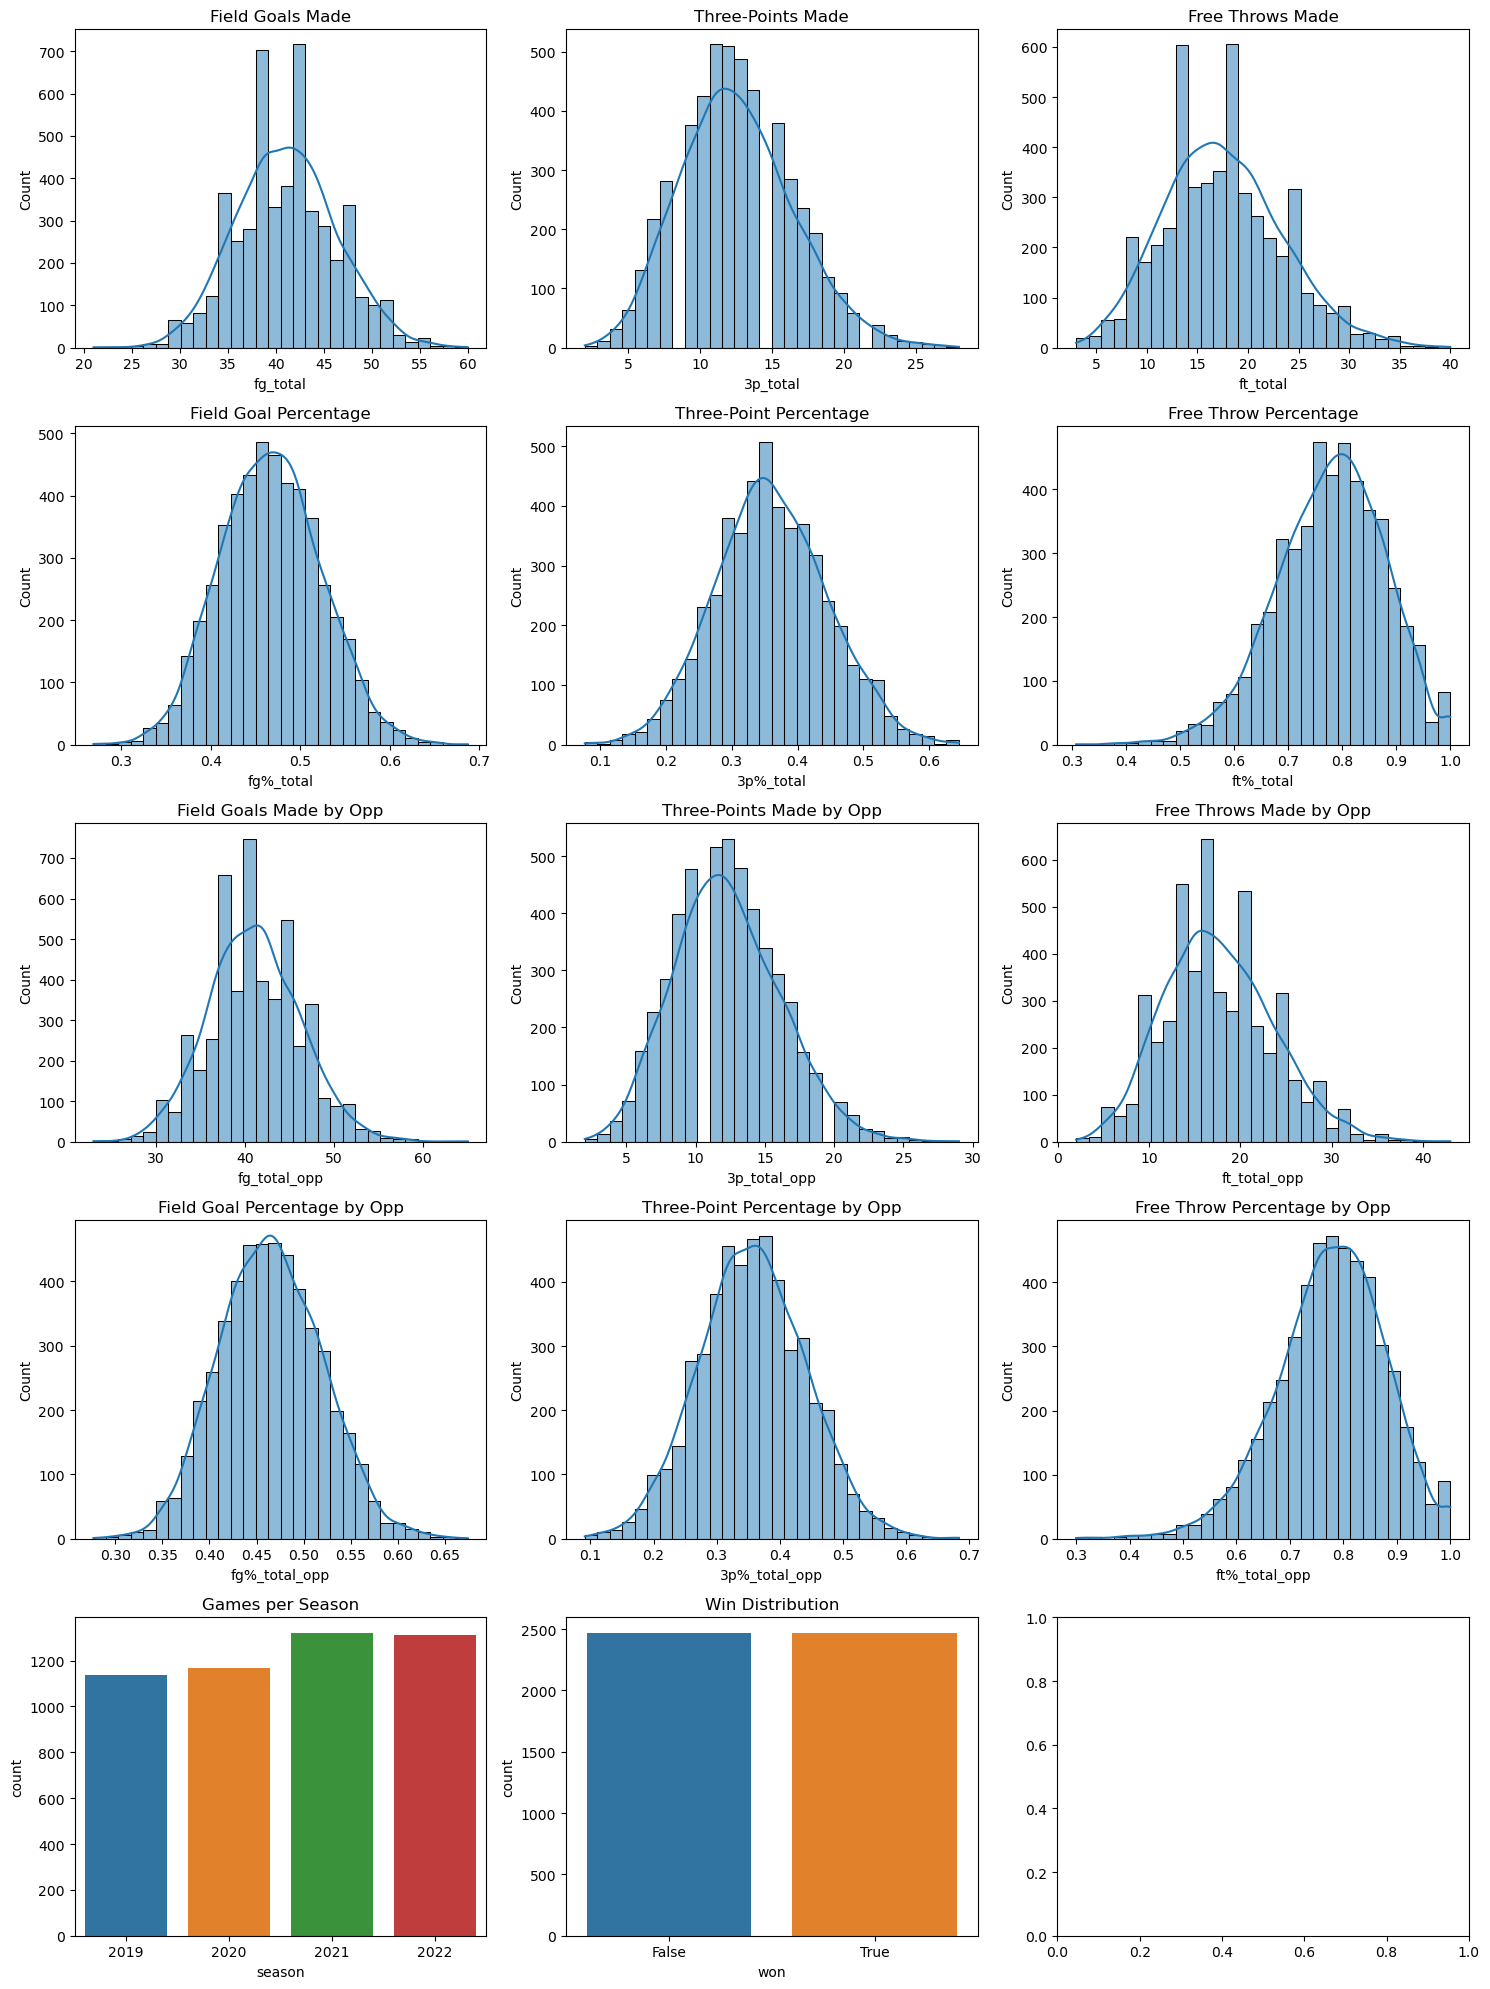

In [11]:

fig, axes = plt.subplots(5, 3, figsize=(15, 20))  # Adjust the subplot grid to 4x3

# Plotting field goals, three-point shots, and free throws
sns.histplot(df['fg_total'], bins=30, kde=True, ax=axes[0, 0]).set_title('Field Goals Made')
sns.histplot(df['3p_total'], bins=30, kde=True, ax=axes[0, 1]).set_title('Three-Points Made')
sns.histplot(df['ft_total'], bins=30, kde=True, ax=axes[0, 2]).set_title('Free Throws Made')

# Plotting percentages for field goals, three-point shots, and free throws
sns.histplot(df['fg%_total'], bins=30, kde=True, ax=axes[1, 0]).set_title('Field Goal Percentage')
sns.histplot(df['3p%_total'], bins=30, kde=True, ax=axes[1, 1]).set_title('Three-Point Percentage')
sns.histplot(df['ft%_total'], bins=30, kde=True, ax=axes[1, 2]).set_title('Free Throw Percentage')

# Plotting field goals, three-point shots, and free throws made by opponents
sns.histplot(df['fg_total_opp'], bins=30, kde=True, ax=axes[2, 0]).set_title('Field Goals Made by Opp')
sns.histplot(df['3p_total_opp'], bins=30, kde=True, ax=axes[2, 1]).set_title('Three-Points Made by Opp')
sns.histplot(df['ft_total_opp'], bins=30, kde=True, ax=axes[2, 2]).set_title('Free Throws Made by Opp')

# Plotting percentages for field goals, three-point shots, and free throws made by opponents
sns.histplot(df['fg%_total_opp'], bins=30, kde=True, ax=axes[3, 0]).set_title('Field Goal Percentage by Opp')
sns.histplot(df['3p%_total_opp'], bins=30, kde=True, ax=axes[3, 1]).set_title('Three-Point Percentage by Opp')
sns.histplot(df['ft%_total_opp'], bins=30, kde=True, ax=axes[3, 2]).set_title('Free Throw Percentage by Opp')

# Plotting games per season and distributions of win and next game outcomes
sns.countplot(x='season', data=df, ax=axes[4, 0]).set_title('Games per Season')
sns.countplot(x='won', data=df, ax=axes[4, 1]).set_title('Win Distribution')

plt.tight_layout()
plt.show()


1. Field Goals Made and Three-Points Made distributions center around a common range, indicating a pattern in scoring strategies across games.
2. Percentage metrics for Field Goals, Three-Points, and Free Throws exhibit a normal distribution, reflecting a standard level of efficiency across matches.
3. The Games per Season distribution shows consistency in the number of games played, which supports analyses over multiple seasons.

In [12]:
def season_trend(column):
    # Check if the column data looks like percentages (values between 0 and 1)
    if df[column].max() <= 1:
        # If so, convert to percentage by multiplying by 100
        seasonal_averages = df.groupby('season')[column].mean() * 100
        ylabel = f'Average {column} (%)'
    else:
        # Otherwise, use the values as is
        seasonal_averages = df.groupby('season')[column].mean()
        ylabel = f'Average {column}'
    
    # Plotting the time series
    plt.figure(figsize=(14, 7))
    seasonal_averages.plot(kind='line', marker='o')
    plt.title(f'Average {column} by NBA Season')
    plt.xlabel('NBA Season')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(ticks=seasonal_averages.index, labels=seasonal_averages.index)
    plt.tight_layout()
    plt.show()

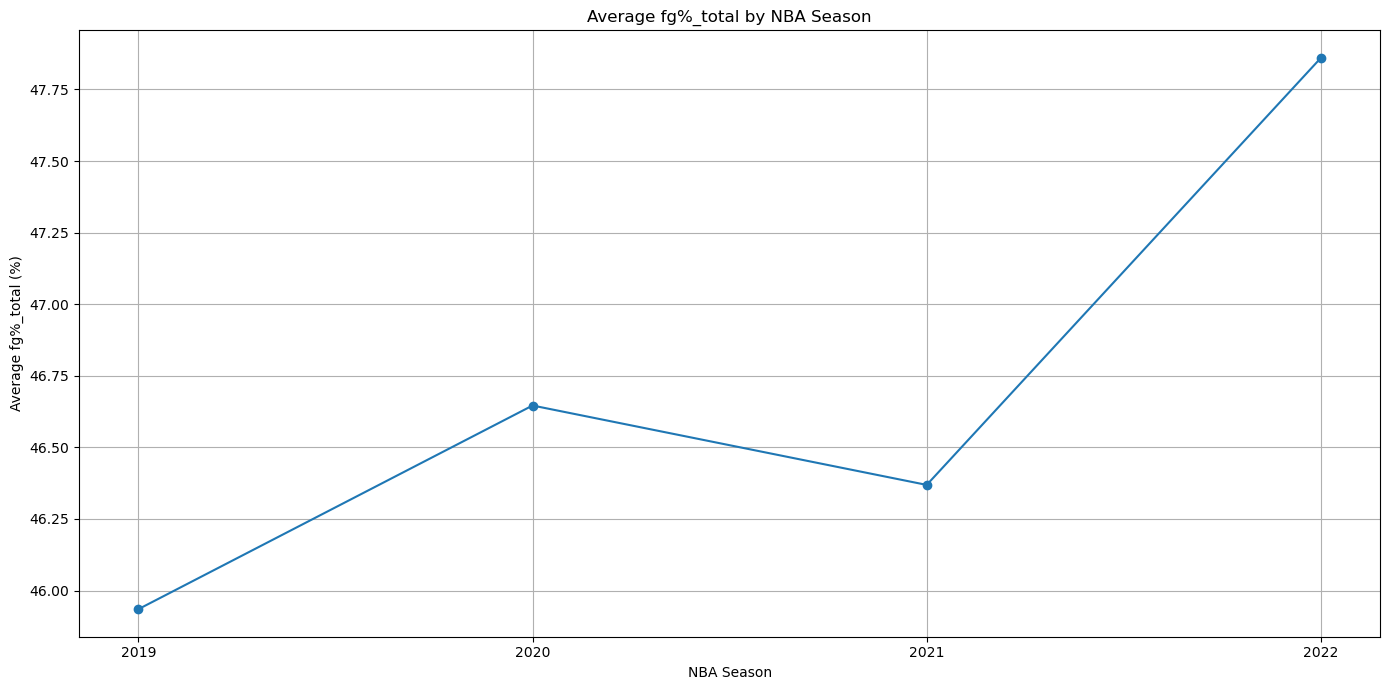

In [13]:
##  Field goal percentage (field goals made divided by field goal attempts)
season_trend('fg%_total')

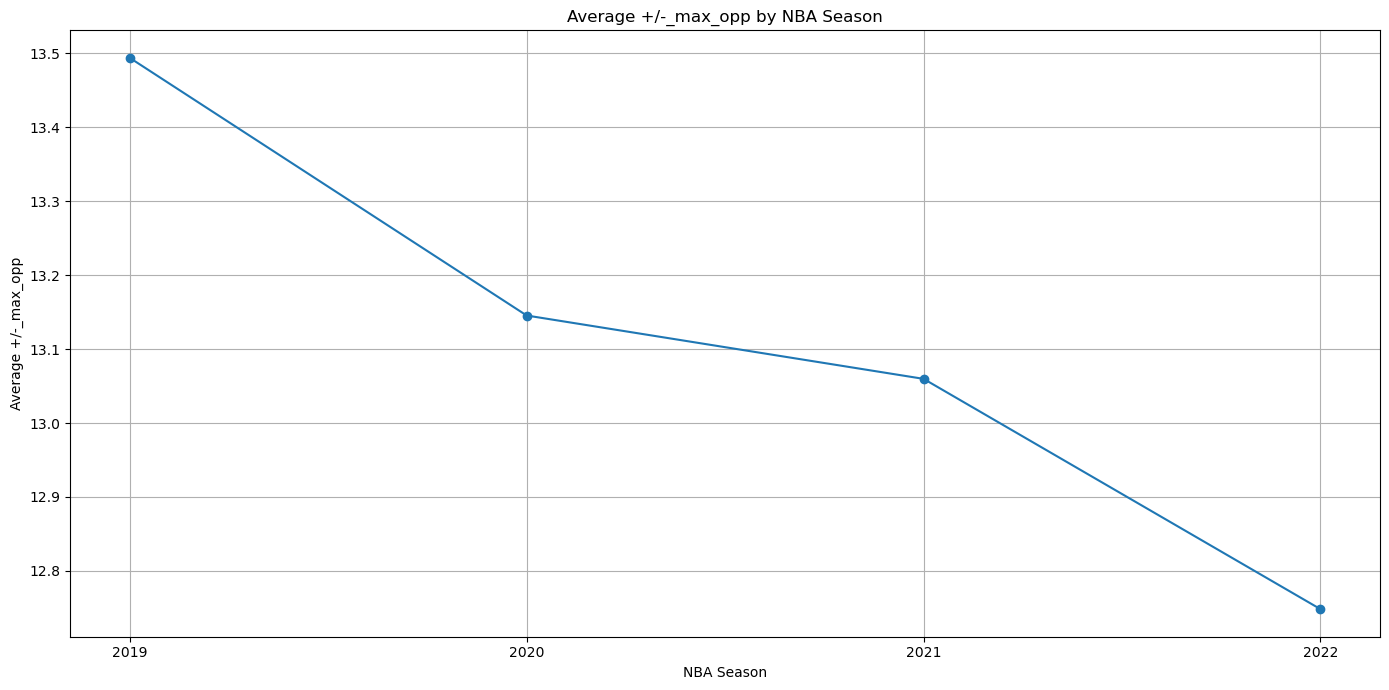

In [14]:
## A statistic that measures the point differential when a player or team is on the court, indicating the impact on the game's score; a positive value means the team outscored opponents, while a negative value indicates being outscored.

season_trend('+/-_max_opp')

In [15]:
def plot_team_performance( metric):
    # Determine if the metric is a percentage (between 0 and 1)
    percentage_scale = df[metric].max() <= 1
    
    # Calculate the average metric for each team per season
    seasonal_team_averages = df.groupby(['season', 'team'])[metric].mean().unstack()

    # Scale up if the metric is a percentage
    if percentage_scale:
        seasonal_team_averages *= 100
        ylabel = f'Average {metric} (%)'
    else:
        ylabel = f'Average {metric}'

    # Identify the top and bottom 5 performing teams
    top_teams = seasonal_team_averages.mean(axis=0).sort_values(ascending=False).head(5).index
    bottom_teams = seasonal_team_averages.mean(axis=0).sort_values(ascending=True).head(5).index

    # Create subplots for the top and bottom performing teams
    fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    # Top 5 performing teams plot
    for team in top_teams:
        axs[0].plot(seasonal_team_averages.index, seasonal_team_averages.loc[:, team], marker='o', label=team)
    axs[0].set_title(f'Top 5 Performing Teams by {metric}')
    axs[0].set_ylabel(ylabel)
    axs[0].grid(True)
    axs[0].legend()

    # Bottom 5 performing teams plot
    for team in bottom_teams:
        axs[1].plot(seasonal_team_averages.index, seasonal_team_averages.loc[:, team], marker='o', label=team)
    axs[1].set_title(f'Bottom 5 Performing Teams by {metric}')
    axs[1].set_ylabel(ylabel)
    axs[1].grid(True)
    axs[1].legend()

    # Set common X label
    plt.xlabel('NBA Season')
    plt.tight_layout()
    plt.show()

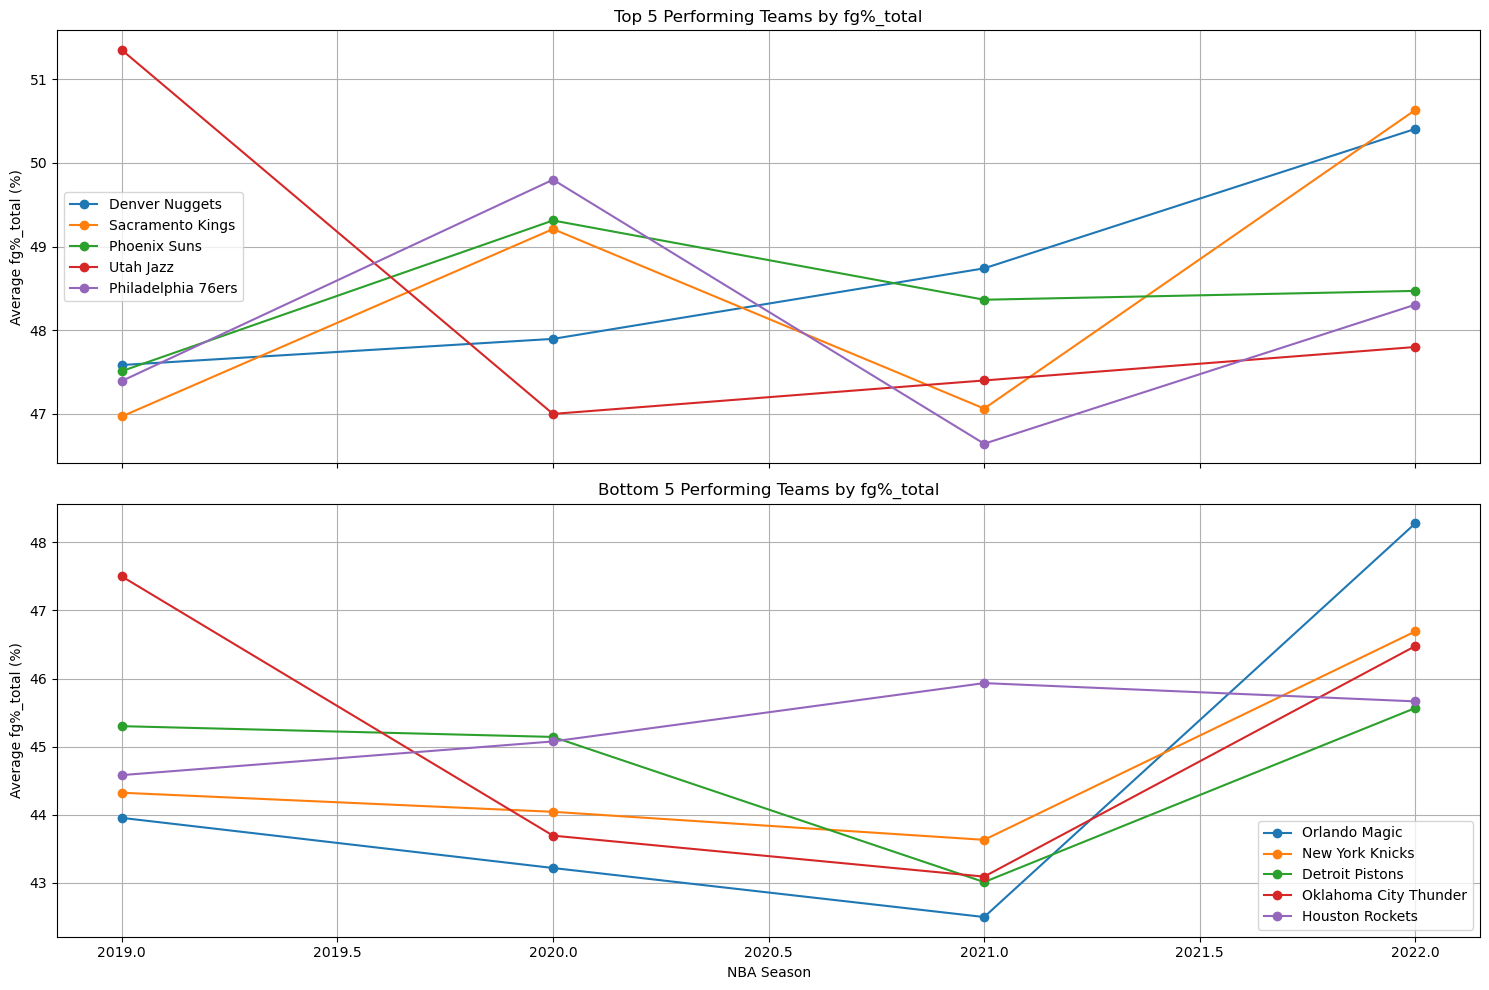

In [16]:
plot_team_performance('fg%_total') 

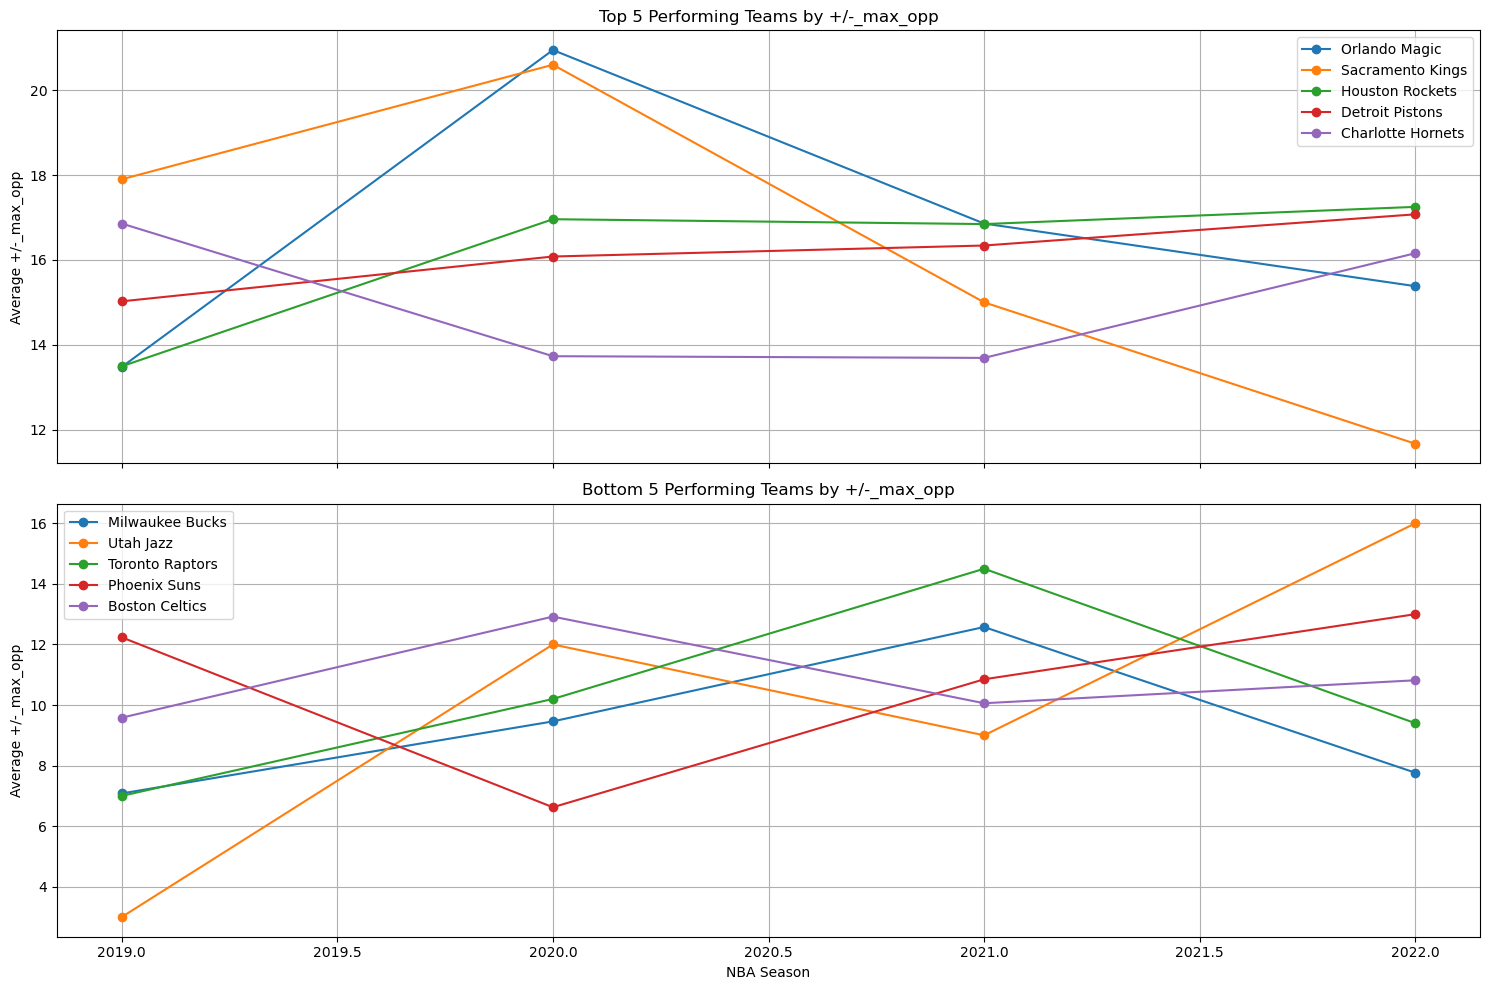

In [17]:
plot_team_performance('+/-_max_opp')

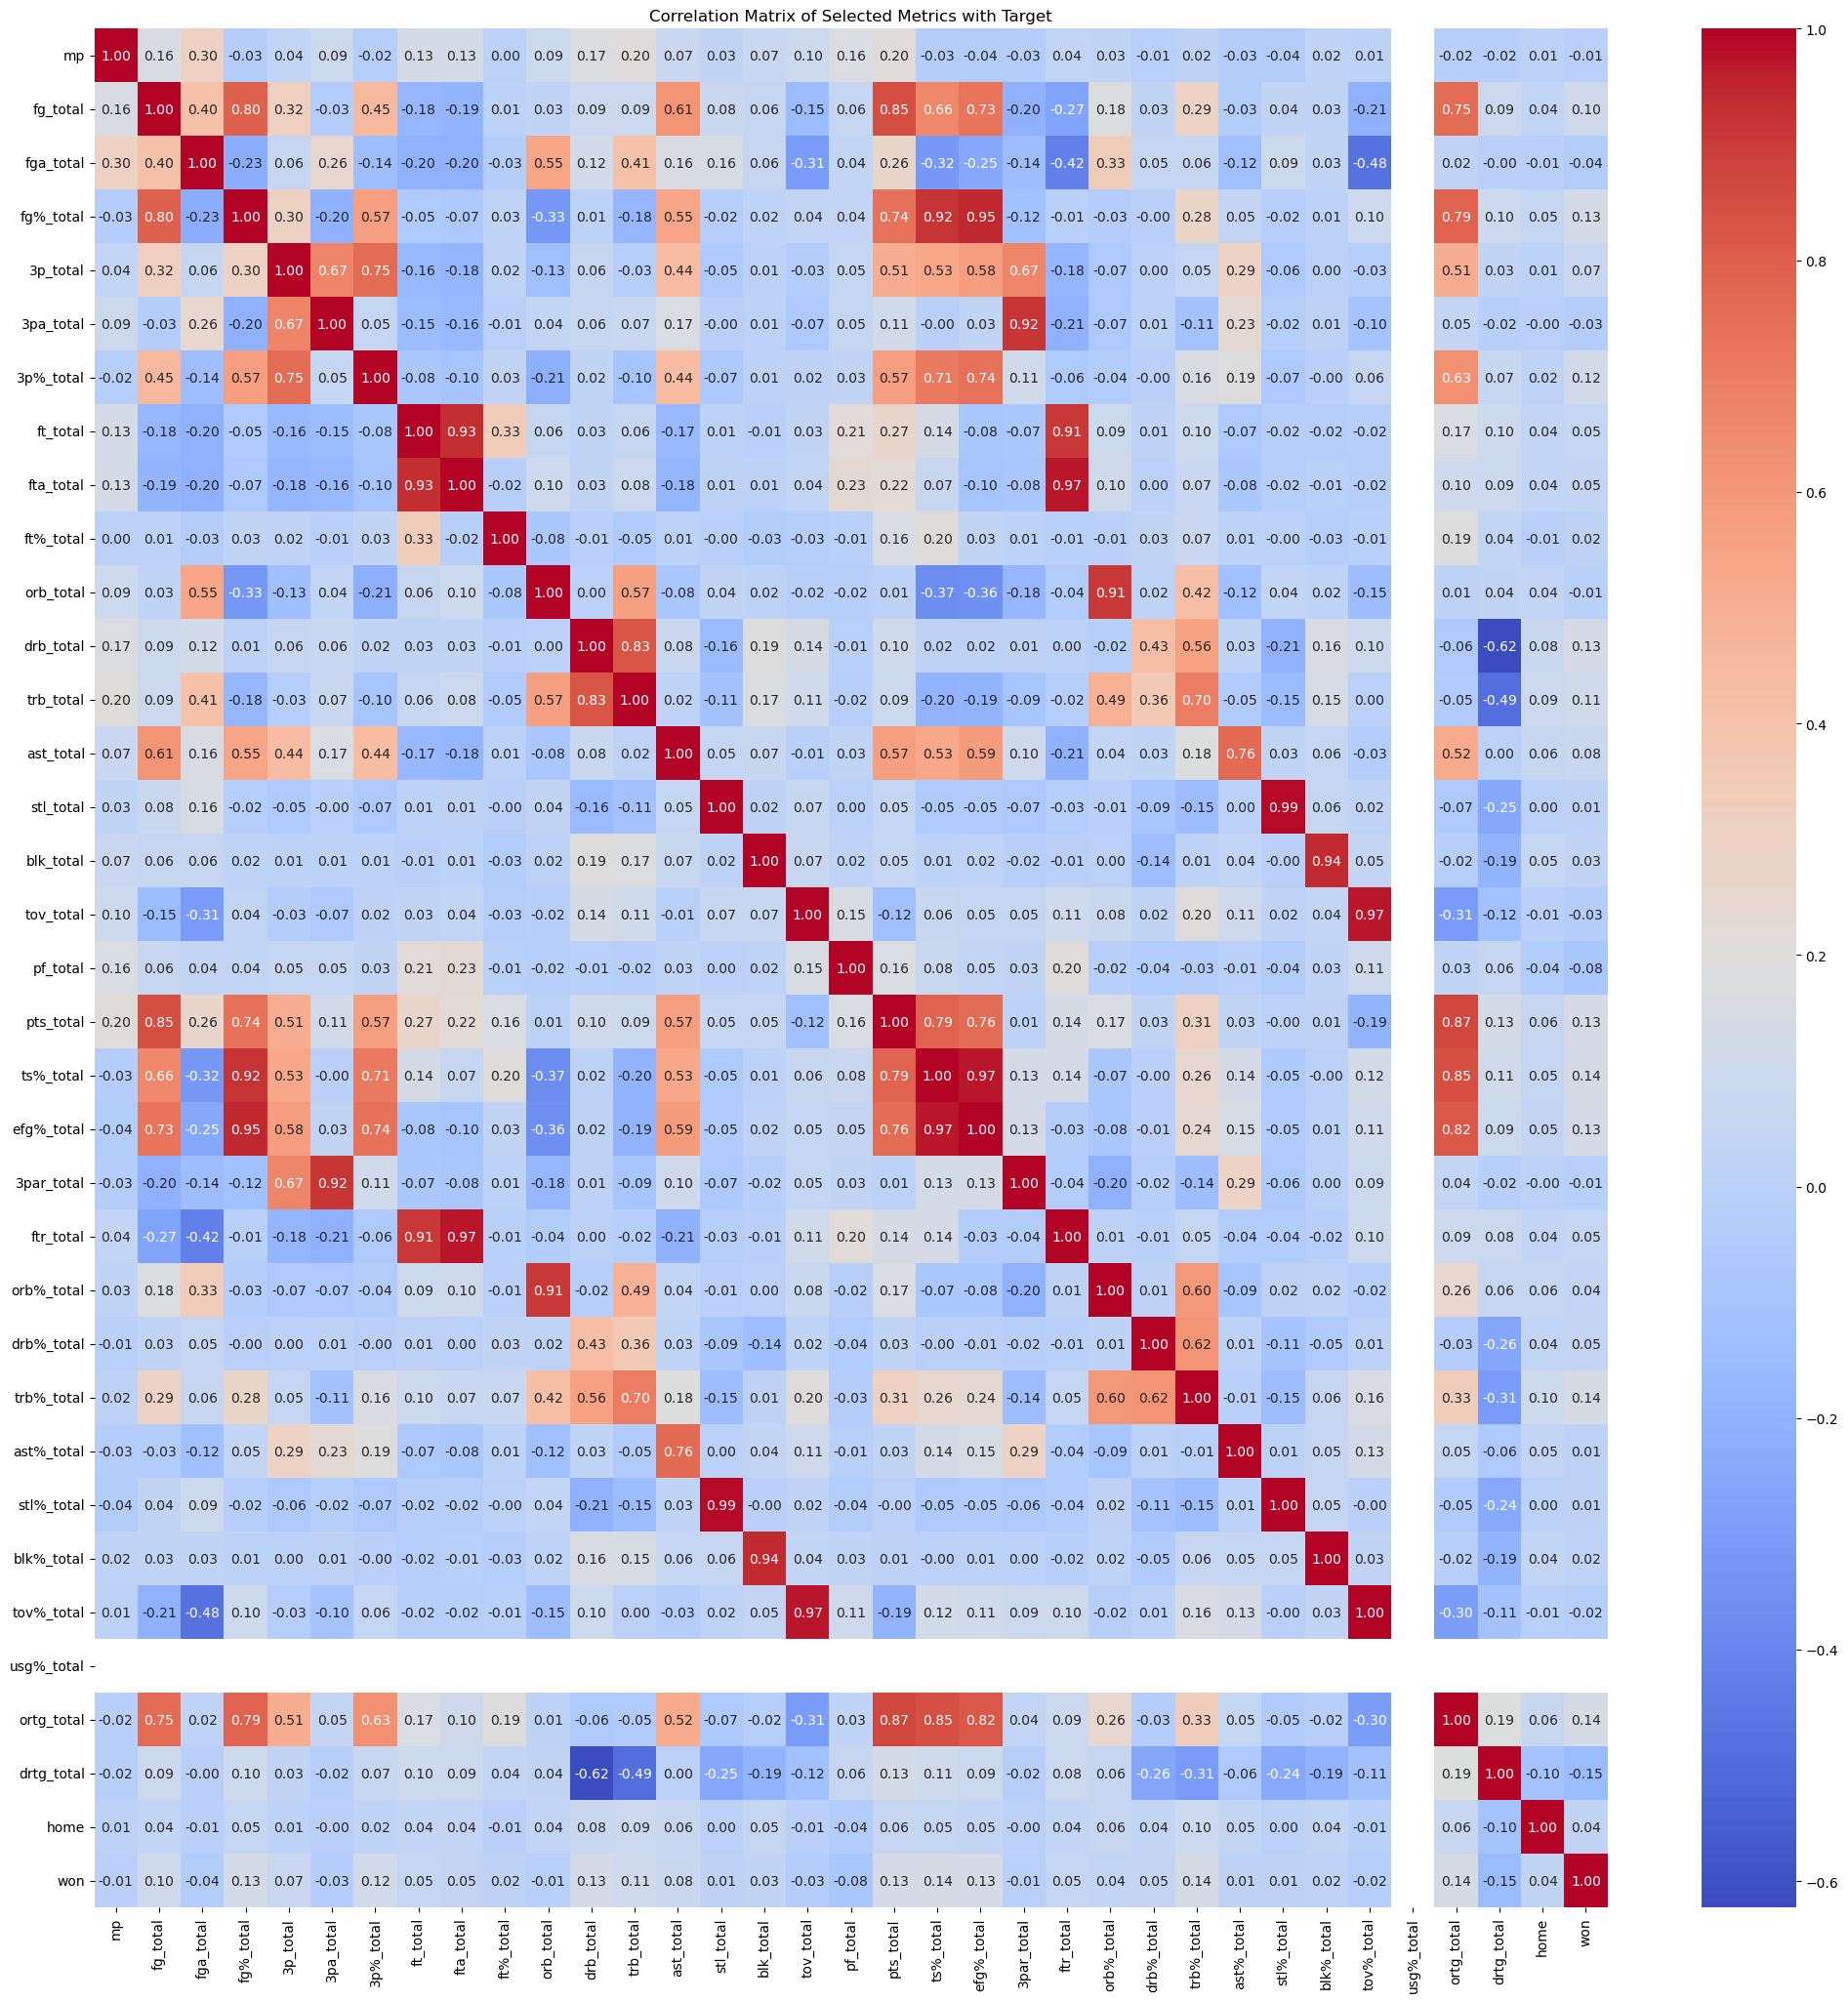

In [18]:


# List of column names correctly passed to the correlation matrix plotting
columns_to_include = [
 'mp', 'fg_total', 'fga_total', 'fg%_total', '3p_total', '3pa_total', '3p%_total',
 'ft_total', 'fta_total', 'ft%_total', 'orb_total', 'drb_total', 'trb_total',
 'ast_total', 'stl_total', 'blk_total', 'tov_total', 'pf_total', 'pts_total',
 'ts%_total', 'efg%_total', '3par_total', 'ftr_total', 'orb%_total', 'drb%_total',
 'trb%_total', 'ast%_total', 'stl%_total', 'blk%_total', 'tov%_total',
 'usg%_total', 'ortg_total', 'drtg_total', 'home', 'won'  # Including only relevant columns
]

# Ensure that all these columns exist in df before using them
if set(columns_to_include).issubset(df.columns):
    fig, ax = plt.subplots(figsize=(25, 25))
    correlation_matrix = df[columns_to_include].corr()
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', ax=ax)
    ax.set_title('Correlation Matrix of Selected Metrics with Target')

    # Save the plot to a file
    plt.savefig('CorrelationMatrix.png')
    
    plt.show()
else:
    print("Some columns are missing in the DataFrame. Please check the column names.")

Multicollinearity Check Using Variance Inflation Factor (VIF)
Purpose: Assessing multicollinearity among predictive features to ensure that the model is not unduly influenced by highly correlated independent variables. This helps in refining the model to improve prediction accuracy and reliability.

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to calculate VIF for each feature and provide specific suggestions
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df["variables"] = data.columns
    vif_df["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    
    # Defining suggestions based on VIF values
    def vif_suggestions(vif_value):
        if vif_value <= 1:
            return "Keep: Not correlated"
        elif 1 < vif_value < 5:
            return "Keep: Moderately correlated"
        elif 5 <= vif_value < 10:
            return "Consider reviewing: Highly correlated"
        else:
            return "Remove or transform: Very high correlation"

    vif_df['Suggestion'] = vif_df['VIF'].apply(vif_suggestions)
    return vif_df

# Selecting numeric features for VIF calculation
numeric_cols = df.select_dtypes(include=[np.number]).columns
vif_data = calculate_vif(df[numeric_cols].dropna())

# Display VIF scores
vif_data = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)
vif_data

,variables,VIF,Suggestion
0,fg_total_opp,inf,Remove or transform: Very high correlation
1,total_opp,inf,Remove or transform: Very high correlation
2,total,inf,Remove or transform: Very high correlation
3,3p_total_opp,inf,Remove or transform: Very high correlation
4,ft_total_opp,inf,Remove or transform: Very high correlation
...,...,...,...
139,season,1.157140,Keep: Moderately correlated
140,ft%_max_opp,1.152367,Keep: Moderately correlated
141,ft%_max,1.143953,Keep: Moderately correlated
142,usg%_total,0.000000,Keep: Not correlated


In [20]:
vif_data['Suggestion'].value_counts()

Suggestion
Remove or transform: Very high correlation    79
Keep: Moderately correlated                   51
Consider reviewing: Highly correlated         12
Keep: Not correlated                           2
Name: count, dtype: int64

Lagged Features for Dynamic Team Performance
Purpose: Creating lagged features to assess how past game performances (e.g., points scored, rebounds) influence the outcome of future games. This analysis helps in understanding team momentum or fatigue, which can be crucial for predicting outcomes of future games.

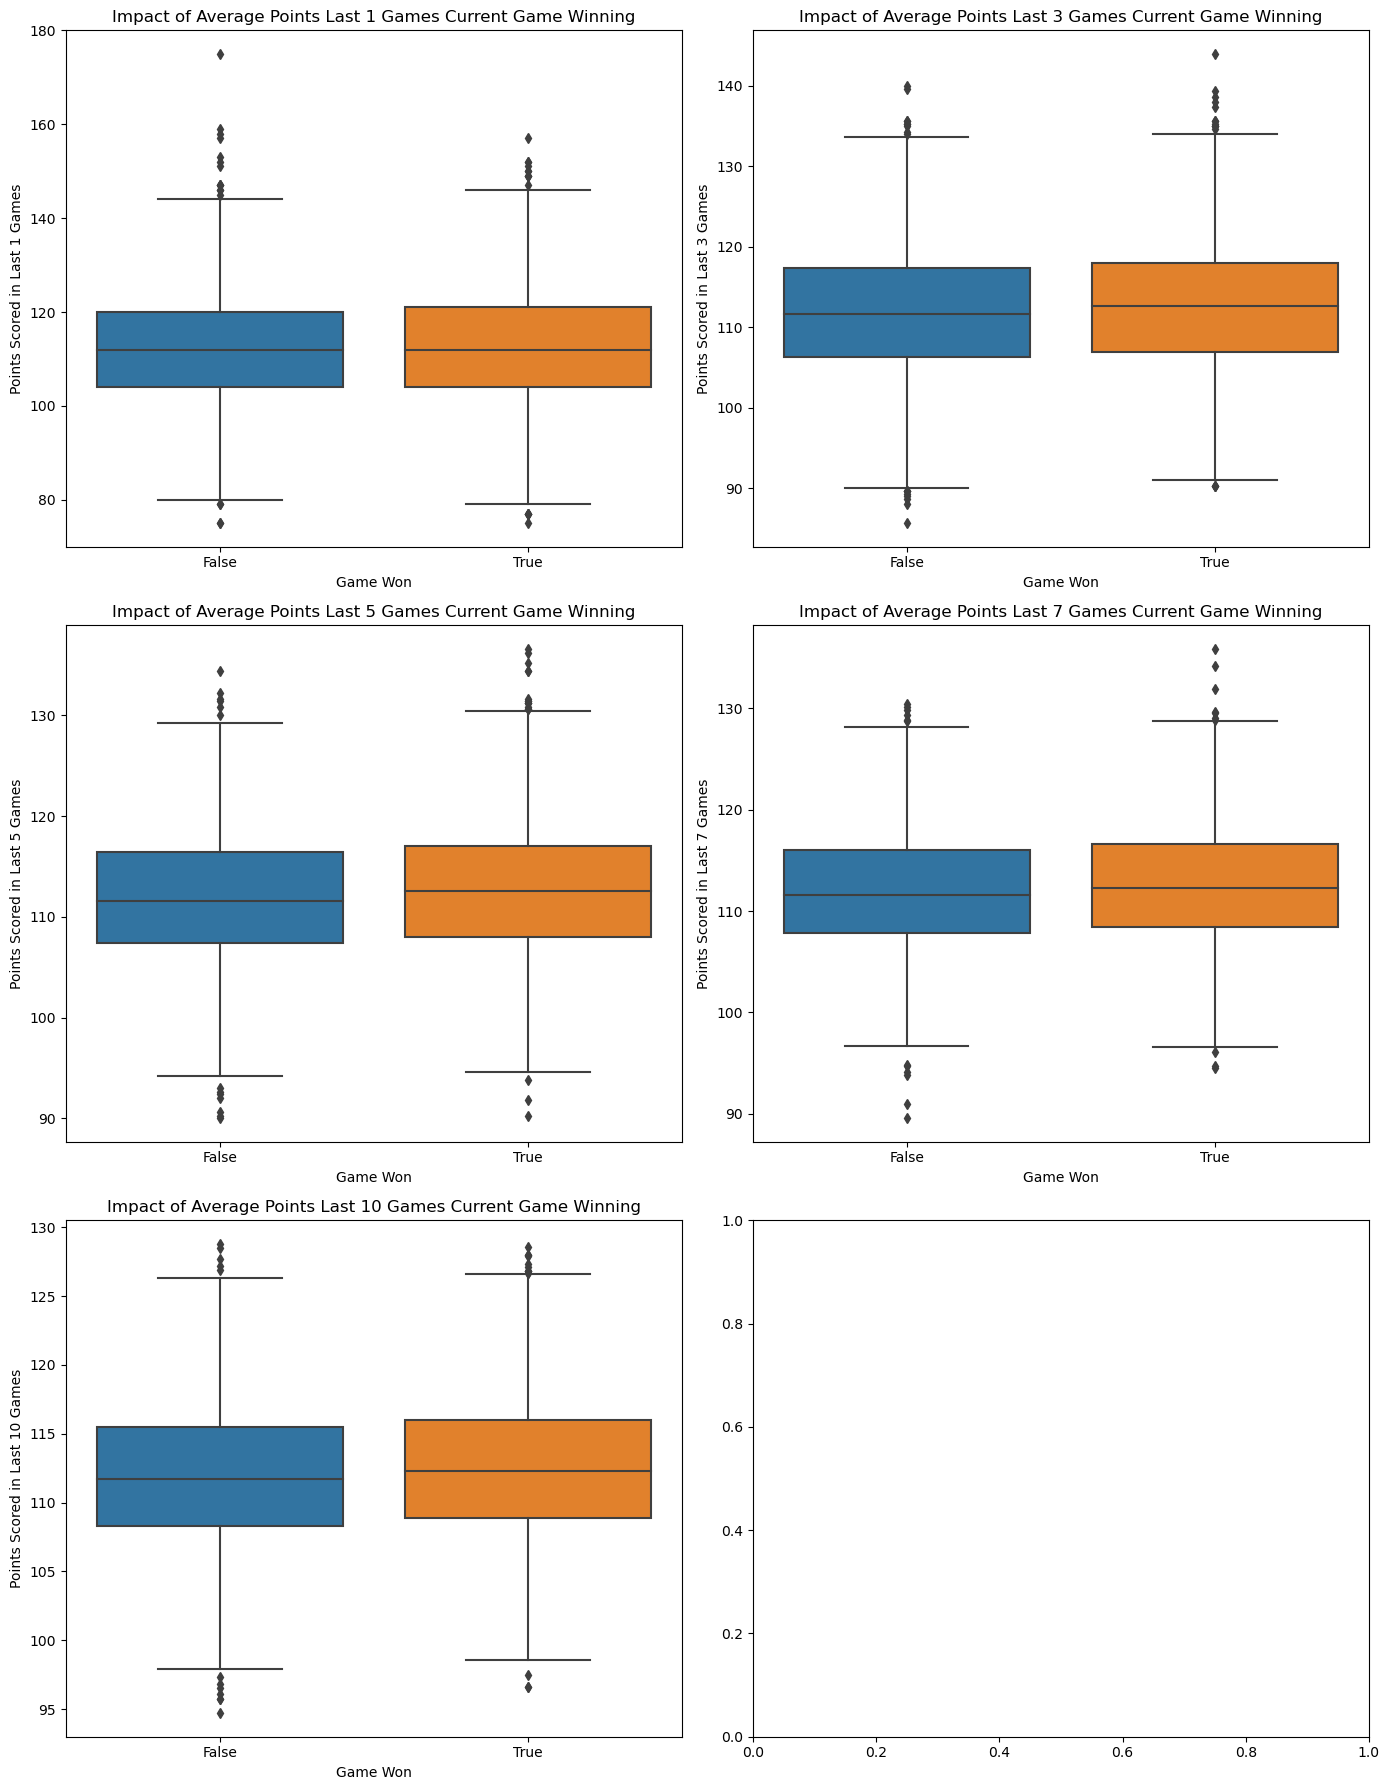

In [21]:

# Define the rolling windows you want to test
rolling_windows = [1, 3, 5, 7, 10]

# Assuming 'df' and 'pts_total' are already defined in your DataFrame
# Create lagged features for each window size
for window in rolling_windows:
    # Create the lagged data for points
    df[f'pts_scored_lag{window}'] = df.groupby('team')['pts_total'].shift(1).rolling(window, min_periods=1).mean().reset_index(level=0, drop=True)


# Drop rows with NaN values in the target column, which will appear at the end of each team's data
df.dropna(subset=['won'], inplace=True)

# Prepare the figure layout
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))
axes = axes.flatten()  # Flatten the array of axes for easier iteration

# Plot the impact of each lagged feature on the target
for i, window in enumerate(rolling_windows):
    sns.boxplot(x='won', y=f'pts_scored_lag{window}', data=df, ax=axes[i])
    axes[i].set_title(f'Impact of Average Points Last {window} Games Current Game Winning')
    axes[i].set_xlabel('Game Won')
    axes[i].set_ylabel(f'Points Scored in Last {window} Games')

# Adjust layout
plt.tight_layout()

# Save the plot to a file
plt.savefig('Impact_of_Lagged_Features_on_Winning.png')

# Show plot
plt.show()


From the visual inspection, Lag 3 & Lag 1(average points from the last 3 games & last game) seems to provide the best balance between capturing enough historical performance to predict future outcomes and not including too much past data which dilutes the predictive power. The slight increase in median points for games that were won suggests that averaging over three games strikes a good balance in this scenario.

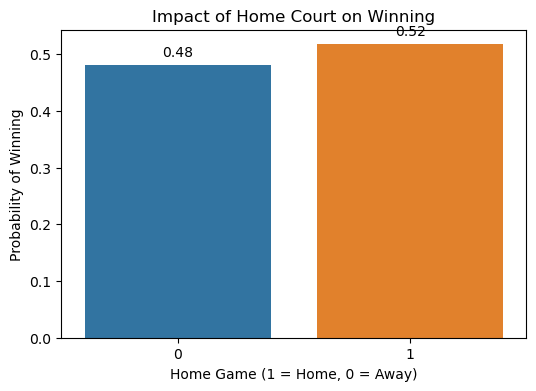

In [22]:


# Plotting the impact of home-court advantage
plt.figure(figsize=(6, 4))
ax = sns.barplot(x='home', y='won', data=df, ci=None)  # ci=None to remove the confidence interval bars
plt.title("Impact of Home Court on Winning")
plt.xlabel("Home Game (1 = Home, 0 = Away)")
plt.ylabel("Probability of Winning")

# Calculate the mean probabilities for annotations
home_winning_probabilities = df.groupby('home')['won'].mean()

# Annotate the bars with the calculated probabilities
for i, p in enumerate(ax.patches):  # access the bars
    ax.annotate(format(home_winning_probabilities.iloc[i], '.2f'),  # format the probability
                (p.get_x() + p.get_width() / 2., p.get_height()),  # position for the text
                ha = 'center', va = 'center',  # center alignment
                xytext = (0, 9),  # position text slightly above the bar
                textcoords = 'offset points')

plt.show()


## Data Preparation

In [23]:
null_columns = df.isnull().sum()
null_columns[null_columns > 0]

pts_scored_lag1     29
pts_scored_lag3      1
pts_scored_lag5      1
pts_scored_lag7      1
pts_scored_lag10     1
dtype: int64

In [24]:
### delete null columns

try:
    df.drop(columns=['pts_scored_lag1','pts_scored_lag3','pts_scored_lag5',
                    'pts_scored_lag7','pts_scored_lag10'], inplace=True)
except:
    pass

In [25]:
null_columns = df.isnull().sum()
null_columns[null_columns > 0]

Series([], dtype: int64)

Checking whether the target column is repeated

In [26]:
target_column = 'won'  

# Find any columns that have the same values as the target column
similar_columns = []
for column in df.columns:
    if column != target_column and df[column].equals(df[target_column]):
        similar_columns.append(column)

if similar_columns:
    print("Columns with identical values to the target column '{}':".format(target_column), similar_columns)
else:
    print("No columns have identical values to the target column '{}'.")

No columns have identical values to the target column '{}'.


In [27]:
df['season'] = df['season'].astype(str)  # Convert 'season' to string type

# Select columns of data type 'category', 'object', and 'bool'
categorical_bool_columns = df.select_dtypes(include=['category', 'object', 'bool']).columns

# Convert to list and remove 'game_id' if it exists in the list
categorical_bool_columns = list(categorical_bool_columns)
if 'game_id' in categorical_bool_columns:
    categorical_bool_columns.remove('game_id')

categorical_bool_columns + ['home']

['team', 'team_opp', 'date', 'won', 'season', 'home']

In [28]:
vif_data['Suggestion'].value_counts()

Suggestion
Remove or transform: Very high correlation    79
Keep: Moderately correlated                   51
Consider reviewing: Highly correlated         12
Keep: Not correlated                           2
Name: count, dtype: int64

In [29]:
vif_safeColumns =  list(vif_data[vif_data['Suggestion'].isin(['Keep: Moderately correlated',
                                                              'Keep: Not correlated'])]['variables']) + categorical_bool_columns

df1 = df[vif_safeColumns].reset_index(drop=True)

def handle_duplicate_columns(df):
    """ Remove duplicate columns by keeping the first occurrence """
    df = df.loc[:, ~df.columns.duplicated()]
    return df


## remove duplicates columns
df1 = handle_duplicate_columns(df1)

df1['home'] = df['home']

print(df1.info())

df1.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4940 entries, 0 to 4939
Data columns (total 58 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   trb%_max_opp    4940 non-null   float64
 1   trb%_max        4940 non-null   float64
 2   +/-_max_opp     4940 non-null   float64
 3   +/-_max         4940 non-null   float64
 4   pf_total_opp    4940 non-null   float64
 5   pf_total        4940 non-null   float64
 6   drb%_max        4940 non-null   float64
 7   fga_max         4940 non-null   float64
 8   drb%_max_opp    4940 non-null   float64
 9   3p_max          4940 non-null   float64
 10  orb_max         4940 non-null   float64
 11  orb_max_opp     4940 non-null   float64
 12  3p_max_opp      4940 non-null   float64
 13  fga_max_opp     4940 non-null   float64
 14  3pa_max         4940 non-null   float64
 15  3pa_max_opp     4940 non-null   float64
 16  fg%_max_opp     4940 non-null   float64
 17  fg%_max         4940 non-null   f

,trb%_max_opp,trb%_max,+/-_max_opp,+/-_max,pf_total_opp,pf_total,drb%_max,fga_max,drb%_max_opp,3p_max,...,season,ft%_max_opp,ft%_max,usg%_total,usg%_total_opp,team,team_opp,date,won,home
0,23.3,18.1,8.0,9.0,16.0,24.0,31.7,23.0,25.5,5.0,...,2019,0.9,1.0,100.0,100.0,Atlanta Hawks,Boston Celtics,2020-01-03,False,0
1,35.8,18.6,19.0,8.0,22.0,19.0,38.3,21.0,31.0,5.0,...,2019,1.0,1.0,100.0,100.0,Atlanta Hawks,Boston Celtics,2020-02-03,False,1


In [30]:

# Data preparation function
def prepare_data(data):
    X = data.drop(columns=['won'])
    y = data['won'].astype(int)

    categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)])

    return X, y, preprocessor, numeric_cols, categorical_cols

# Train and evaluate function
def train_and_evaluate(X, y, preprocessor, numeric_cols, categorical_cols, top_features=20, model_type='logistic'):
    if model_type == 'logistic':
        classifier = LogisticRegression(solver='liblinear', random_state=42)
    elif model_type == 'svm':
        classifier = SVC(probability=True, random_state=42)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    clf = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Cross-validation with StratifiedKFold to prevent data leakage
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(clf, X, y, cv=skf, scoring='accuracy')
    print(f"Cross-Validation Scores: {cv_scores}")
    print(f"Mean CV Accuracy: {np.mean(cv_scores)}")

    # Fit the model on the whole dataset
    clf.fit(X, y)

    # Access the preprocessor step
    preprocessor_fitted = clf.named_steps['preprocessor']
    X_transformed = preprocessor_fitted.transform(X)

    # Get feature names from the fitted preprocessor
    feature_names = numeric_cols
    
    # Initialize SHAP explainer and compute SHAP values
    explainer = shap.Explainer(clf.named_steps['classifier'], X_transformed)
    shap_values = explainer.shap_values(X_transformed)

    # Summarize the SHAP values to find the top features
    shap_sum = np.abs(shap_values).mean(axis=0)
    feature_importance = pd.DataFrame(list(zip(feature_names, shap_sum)), columns=['feature', 'shap_importance']).sort_values(by='shap_importance', ascending=False)

    top_features_df = feature_importance.head(top_features).reset_index(drop=True)
    print("Top Features Based on SHAP values:\n", top_features_df)

    # Plotting SHAP values for top features
    shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)

    return clf, explainer, shap_values, top_features_df



Cross-Validation Scores: [0.67611336 0.64473684 0.64878543 0.65789474 0.66093117]
Mean CV Accuracy: 0.6576923076923078
Top Features Based on SHAP values:
          feature  shap_importance
0        +/-_max         0.261743
1    +/-_max_opp         0.202064
2       pf_total         0.159773
3   pf_total_opp         0.134993
4    fg%_max_opp         0.095438
5       ast%_max         0.066183
6    3pa_max_opp         0.062134
7        3pa_max         0.060986
8   3par_max_opp         0.050891
9       drtg_max         0.048191
10  ast%_max_opp         0.047735
11   ast_max_opp         0.044156
12       fg%_max         0.040802
13   tov_max_opp         0.040445
14       tov_max         0.031434
15       ast_max         0.030694
16   orb_max_opp         0.030163
17       stl_max         0.029280
18   blk_max_opp         0.028017
19      ortg_max         0.026923


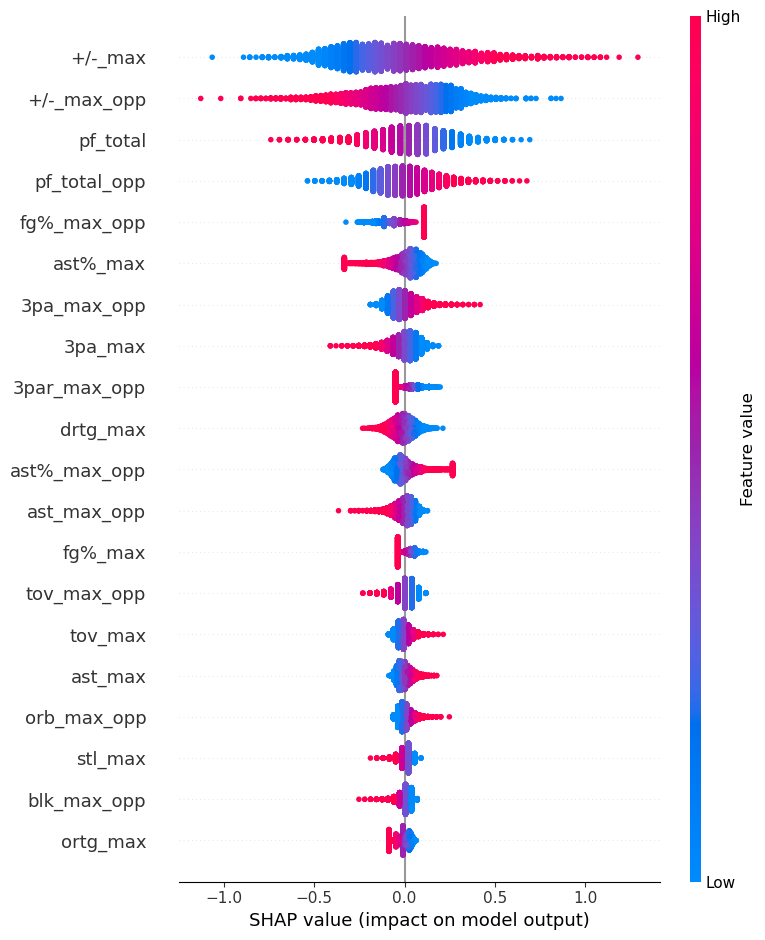

In [31]:
selected_features = [
    '+/-_max', '+/-_max_opp',
    'ortg_max', 'drtg_max',
    'usg%_total', 'usg%_total_opp',
    'home',
    'fg%_max', 'fg%_max_opp',
    '3p%_max', '3p%_max_opp',
    'ft%_max', 'ft%_max_opp',
    'fga_max', 'fga_max_opp',
    '3pa_max', '3pa_max_opp',
    'orb_max', 'orb_max_opp',
    'drb%_max', 'drb%_max_opp',
    'blk_max', 'blk_max_opp',
    'tov_max', 'tov_max_opp',
    'stl_max', 'stl_max_opp',
    'pf_total', 'pf_total_opp',
    'ast_max', 'ast_max_opp',
    'ast%_max', 'ast%_max_opp',
    '3par_max', '3par_max_opp',
    'ftr_max', 'ftr_max_opp',
    'blk%_max', 'blk%_max_opp',
    'stl%_max', 'stl%_max_opp',
]

# Assuming df1 is your DataFrame
df_selected = df[selected_features + ['won']]

# Example usage
# Assuming df_selected is your DataFrame with 'won' column included
X, y, preprocessor, numeric_cols, categorical_cols = prepare_data(df_selected)
model, explainer, shap_values, top_features_df = train_and_evaluate(X, y, preprocessor, numeric_cols, categorical_cols, top_features=20, model_type='logistic')


In [32]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4940 entries, 0 to 4939
Data columns (total 42 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   +/-_max         4940 non-null   float64
 1   +/-_max_opp     4940 non-null   float64
 2   ortg_max        4940 non-null   float64
 3   drtg_max        4940 non-null   float64
 4   usg%_total      4940 non-null   float64
 5   usg%_total_opp  4940 non-null   float64
 6   home            4940 non-null   int64  
 7   fg%_max         4940 non-null   float64
 8   fg%_max_opp     4940 non-null   float64
 9   3p%_max         4940 non-null   float64
 10  3p%_max_opp     4940 non-null   float64
 11  ft%_max         4940 non-null   float64
 12  ft%_max_opp     4940 non-null   float64
 13  fga_max         4940 non-null   float64
 14  fga_max_opp     4940 non-null   float64
 15  3pa_max         4940 non-null   float64
 16  3pa_max_opp     4940 non-null   float64
 17  orb_max         4940 non-null   f

Domain short listed

1. usg%_max (Usage Rate Max): Measures the percentage of team plays a player uses while on the floor.
2. trb%_max (Total Rebound Percentage Max): Indicates a player's or team's efficiency in grabbing available rebounds.
3. ts%_max (True Shooting Percentage Max): An overall measure of shooting efficiency.
4. pts_max (Points Max): Highest points scored in a game.
5. ast_total (Total Assists): Total assists provided in a game.

In [33]:
### Filtering only on SHAP Values

df2 = df[list(top_features_df['feature']) + ['home',"season", "date", "won", "team",
                                                      "team_opp"] + ['usg%_max','trb%_max','ts%_max', 'pts_max', 'ast_total']] ## Domain 
df2.head(2)

,+/-_max,+/-_max_opp,pf_total,pf_total_opp,fg%_max_opp,ast%_max,3pa_max_opp,3pa_max,3par_max_opp,drtg_max,...,season,date,won,team,team_opp,usg%_max,trb%_max,ts%_max,pts_max,ast_total
0,9.0,8.0,24.0,16.0,0.615,48.0,6.0,14.0,0.75,112.0,...,2019,2020-01-03,False,Atlanta Hawks,Boston Celtics,36.4,18.1,0.810,28.0,26.0
1,8.0,19.0,19.0,22.0,1.000,33.2,9.0,11.0,1.00,129.0,...,2019,2020-02-03,False,Atlanta Hawks,Boston Celtics,41.5,18.6,1.064,34.0,22.0


In [34]:
list(top_features_df['feature'])

['+/-_max',
 '+/-_max_opp',
 'pf_total',
 'pf_total_opp',
 'fg%_max_opp',
 'ast%_max',
 '3pa_max_opp',
 '3pa_max',
 '3par_max_opp',
 'drtg_max',
 'ast%_max_opp',
 'ast_max_opp',
 'fg%_max',
 'tov_max_opp',
 'tov_max',
 'ast_max',
 'orb_max_opp',
 'stl_max',
 'blk_max_opp',
 'ortg_max']

## Prepped Data Review

In [35]:
# Generate descriptive statistics for key metrics
key_metrics = ['+/-_max', '+/-_max_opp', 'pf_total', 'pf_total_opp','fg%_max_opp','usg%_max','trb%_max','ts%_max', 'pts_max', 'ast_total']

# Selecting the key metrics and generating descriptive statistics
key_stats_summary = df2[key_metrics].describe()

# Display the descriptive statistics for key metrics
key_stats_summary

,+/-_max,+/-_max_opp,pf_total,pf_total_opp,fg%_max_opp,usg%_max,trb%_max,ts%_max,pts_max,ast_total
count,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000
mean,13.451822,13.097368,19.957085,19.996559,0.826859,35.148866,25.108158,0.963788,28.261336,24.826923
std,9.180685,9.063678,4.152267,4.177838,0.158259,8.277439,9.646613,0.212091,7.042255,4.974220
min,-16.000000,-18.000000,6.000000,7.000000,0.350000,22.100000,9.100000,0.500000,11.000000,9.000000
25%,6.750000,6.000000,17.000000,17.000000,0.667000,30.200000,19.300000,0.810000,23.000000,21.000000
50%,13.000000,12.000000,20.000000,20.000000,0.800000,33.500000,23.000000,0.940000,27.000000,25.000000
75%,19.000000,19.000000,23.000000,23.000000,1.000000,37.800000,28.200000,1.031000,32.000000,28.000000
max,52.000000,54.000000,36.000000,37.000000,1.000000,100.000000,100.000000,1.500000,62.000000,47.000000


In [36]:
# Generate descriptive statistics for key metrics
key_metrics_opp = ['+/-_max', '+/-_max_opp', 'pf_total', 'pf_total_opp','fg%_max_opp','usg%_max','trb%_max','ts%_max', 'pts_max', 'ast_total']

# Selecting the key metrics and generating descriptive statistics
key_stats_summary_opp = df2[key_metrics_opp].describe()

# Display the descriptive statistics for key metrics
key_stats_summary_opp

,+/-_max,+/-_max_opp,pf_total,pf_total_opp,fg%_max_opp,usg%_max,trb%_max,ts%_max,pts_max,ast_total
count,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000,4940.000000
mean,13.451822,13.097368,19.957085,19.996559,0.826859,35.148866,25.108158,0.963788,28.261336,24.826923
std,9.180685,9.063678,4.152267,4.177838,0.158259,8.277439,9.646613,0.212091,7.042255,4.974220
min,-16.000000,-18.000000,6.000000,7.000000,0.350000,22.100000,9.100000,0.500000,11.000000,9.000000
25%,6.750000,6.000000,17.000000,17.000000,0.667000,30.200000,19.300000,0.810000,23.000000,21.000000
50%,13.000000,12.000000,20.000000,20.000000,0.800000,33.500000,23.000000,0.940000,27.000000,25.000000
75%,19.000000,19.000000,23.000000,23.000000,1.000000,37.800000,28.200000,1.031000,32.000000,28.000000
max,52.000000,54.000000,36.000000,37.000000,1.000000,100.000000,100.000000,1.500000,62.000000,47.000000


1. Points Differential (+/-):
The average points differential for teams (+/-_max: 13.45) and their opponents (+/-_max_opp: 13.09) suggests closely matched games.
2. Usage and Rebounds (usg%_max, trb%_max):
Teams have an average usage rate of 35.14% and a total rebound percentage of 25.11%, indicating the involvement of key players in scoring and rebounding opportunities.
3. Shooting Efficiency (ts%_max):
Teams achieve a true shooting percentage (accounting for field goals, 3-pointers, and free throws) of 96.38% on average, highlighting their overall scoring efficiency.

## Machine Learning Models

Approach 1: 
1. What statistical indicators are most influential in determining the winning team?
2. Can historical NBA game statistics be utilized to predict the outcome of a game? 

In [37]:

def train_and_evaluate_models(X, y, scaler,Approach, models):
    """Train and evaluate models using TimeSeriesSplit, handling multicollinearity, and return model metrics."""
    model_metrics = {}

    ### Scaling the data
    X_scaled = scaler.fit_transform(X)
    X_filtered = pd.DataFrame(X_scaled, columns=X.columns)

    tscv = TimeSeriesSplit(n_splits=5)
    for name, model in models.items():
        scores = []
        detailed_reports = []
        for train_index, test_index in tscv.split(X_filtered):
            X_train, X_test = X_filtered.iloc[train_index], X_filtered.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = accuracy_score(y_test, y_pred)
            scores.append(score)
            report = classification_report(y_test, y_pred, output_dict=True)
            detailed_reports.append(report)

        avg_score = np.mean(scores)
        model_metrics[name] = {
            'Model': model,
            'CV Scores': scores,
            'Average CV Score': avg_score,
            'Classification Reports': detailed_reports
        }
        print(f"{name} Model Metrics:")
        print("Cross-Validation Scores:", scores)
        print("Average CV Score:", avg_score)
        print("Classification Reports for the last split:")
        print(classification_report(y_test, y_pred))

        model_directory = 'models'
        os.makedirs(model_directory, exist_ok=True)
        model_path = f"{model_directory}/{name}_Approach{Approach}.pkl"
        with open(model_path, 'wb') as file:
            pickle.dump(model, file)


    return model_metrics, X_filtered, y


# Example usage would be the same as before, initializing and calling these functions accordingly.


In [38]:
def plot_learning_curve(estimator, title, X, y, cv):
    """Plot and save the learning curve for the given estimator."""
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))
    
    # Calculate means and standard deviations for the training and test sets
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.ylim(0.4, 1.1)
    plt.yticks(np.arange(0.4, 1.1, 0.1))
    plt.grid()

    # Plot the standard deviation as a shaded area around the mean
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # Plot the mean score for training and test sets
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    plt.savefig(f'{title}.png')
    plt.show()



def format_classification_report(reports):
    """Formats and prints average classification report from multiple splits."""
    print("Average Classification Metrics:")
    for key in ['precision', 'recall', 'f1-score']:
        avg_metric = np.mean([report['macro avg'][key] for report in reports])
        print(f"{key.capitalize()}: {avg_metric:.2f}")

def select_and_plot_best_model(model_metrics, X, y):
    """Select the best model based on CV scores and plot its learning curve."""
    best_model_name = max(model_metrics, key=lambda x: model_metrics[x]['Average CV Score'])
    best_model = model_metrics[best_model_name]['Model']

    print(f"Selected Best Model: {best_model_name}")
    print("Cross-Validation Scores:", model_metrics[best_model_name]['CV Scores'])
    print(f"Average CV Score: {model_metrics[best_model_name]['Average CV Score']}")
    format_classification_report(model_metrics[best_model_name]['Classification Reports'])

    plot_learning_curve(best_model, f"Learning Curve for {best_model_name}", X, y, cv=StratifiedKFold(n_splits=5))


In [39]:
# checking the datatypes of the X values
df_approach1 = df2.copy()
df_approach1['date'] = pd.to_datetime(df_approach1['date'])
df_approach1.sort_values('date', inplace=True)
predictors = [col for col in df_approach1.columns if col not in ["season", "date", "won", "team", "team_opp"]]
test = df_approach1[predictors]
test.head(2)

,+/-_max,+/-_max_opp,pf_total,pf_total_opp,fg%_max_opp,ast%_max,3pa_max_opp,3pa_max,3par_max_opp,drtg_max,...,orb_max_opp,stl_max,blk_max_opp,ortg_max,home,usg%_max,trb%_max,ts%_max,pts_max,ast_total
4320,11.0,18.0,34.0,24.0,0.667,27.6,11.0,7.0,0.733,124.0,...,6.0,2.0,2.0,146.0,0,37.7,17.1,1.0,22.0,30.0
3198,15.0,7.0,25.0,24.0,1.000,29.0,9.0,7.0,1.000,116.0,...,3.0,4.0,2.0,203.0,1,42.4,17.8,1.0,30.0,24.0


In [40]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4940 entries, 4320 to 2152
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   +/-_max       4940 non-null   float64
 1   +/-_max_opp   4940 non-null   float64
 2   pf_total      4940 non-null   float64
 3   pf_total_opp  4940 non-null   float64
 4   fg%_max_opp   4940 non-null   float64
 5   ast%_max      4940 non-null   float64
 6   3pa_max_opp   4940 non-null   float64
 7   3pa_max       4940 non-null   float64
 8   3par_max_opp  4940 non-null   float64
 9   drtg_max      4940 non-null   float64
 10  ast%_max_opp  4940 non-null   float64
 11  ast_max_opp   4940 non-null   float64
 12  fg%_max       4940 non-null   float64
 13  tov_max_opp   4940 non-null   float64
 14  tov_max       4940 non-null   float64
 15  ast_max       4940 non-null   float64
 16  orb_max_opp   4940 non-null   float64
 17  stl_max       4940 non-null   float64
 18  blk_max_opp   4940 non-null   

In [41]:
# Usage example
df_approach1 = df2.copy()
df_approach1['date'] = pd.to_datetime(df_approach1['date'])
df_approach1.sort_values('date', inplace=True)
predictors = [col for col in df_approach1.columns if col not in ["season", "date", "won", "team", "team_opp"]]
X = df_approach1[predictors]
y = df_approach1['won']
scaler = MinMaxScaler()

In [42]:


models = {
    'logistic_regression': LogisticRegression(
        penalty='l2',  # 'l1' or 'elasticnet' also possible
        C=0.01,  # Regularization strength (smaller values specify stronger regularization)
        max_iter=1000,
        solver='liblinear'  # Suitable solver for 'l1' penalty
    ),
    'svm': SVC(
        probability=True,
        C=0.05,  # Regularization strength (smaller values specify stronger regularization)
        kernel='rbf',  # Commonly used kernel with SVMs
        gamma='scale'  # Kernel coefficient
    ),
'xgboost' : XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    alpha=0.05,  # Increased L1 regularization
    reg_lambda=0.05,  # Increased L2 regularization
    max_depth=4,
    min_child_weight=5,
    learning_rate=0.05
)
}

In [43]:
# Start time

from datetime import datetime
import time

start_time = time.time()
start_dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("Started at = ", start_dt_string)

###
approach1_model_metrics, approach1_X_filtered, approach1_y = train_and_evaluate_models(X, y, scaler, Approach = 1, models = models)

# End time
end_time = time.time()
end_dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("Ended at = ", end_dt_string)
print(f"Total processing time: {(end_time - start_time) / 60:.2f} minutes.")

Started at =  09/05/2024 03:56:53
logistic_regression Model Metrics:
Cross-Validation Scores: [0.5273390036452005, 0.6233292831105711, 0.6136087484811664, 0.6962332928311057, 0.7193195625759417]
Average CV Score: 0.6359659781287972
Classification Reports for the last split:
              precision    recall  f1-score   support

       False       0.70      0.75      0.72       406
        True       0.74      0.69      0.71       417

    accuracy                           0.72       823
   macro avg       0.72      0.72      0.72       823
weighted avg       0.72      0.72      0.72       823

svm Model Metrics:
Cross-Validation Scores: [0.479951397326853, 0.5844471445929527, 0.6002430133657352, 0.7035236938031592, 0.7424058323207776]
Average CV Score: 0.6221142162818956
Classification Reports for the last split:
              precision    recall  f1-score   support

       False       0.74      0.73      0.74       406
        True       0.74      0.75      0.75       417

    accura

Started at =  09/05/2024 03:57:25
Selected Best Model: xgboost
Cross-Validation Scores: [0.732685297691373, 0.732685297691373, 0.7375455650060754, 0.7800729040097205, 0.8177399756986634]
Average CV Score: 0.760145808019441
Average Classification Metrics:
Precision: 0.76
Recall: 0.76
F1-score: 0.76


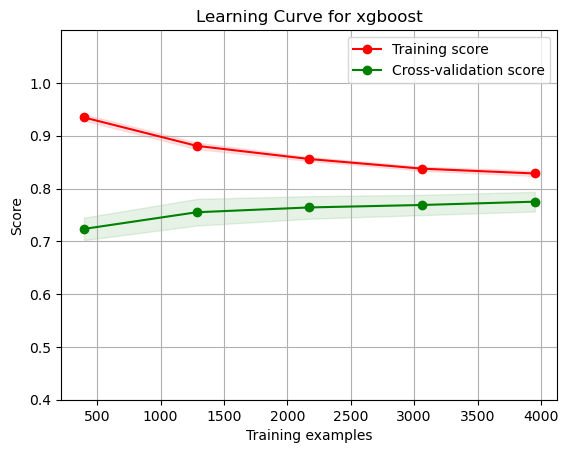

Ended at =  09/05/2024 03:57:30
Total processing time: 0.08 minutes.


In [44]:

# Start time
start_time = time.time()
start_dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("Started at = ", start_dt_string)

#### 
select_and_plot_best_model(approach1_model_metrics, approach1_X_filtered, approach1_y)

# End time
end_time = time.time()
end_dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("Ended at = ", end_dt_string)
print(f"Total processing time: {(end_time - start_time) / 60:.2f} minutes.")

Approach 2:

3. Can the prediction model adapt dynamically to in-season changes such as player 
performance trends? 
4. How does the home-court advantage factor into the predictive model?

In [45]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assume approach2_df2 is your DataFrame already loaded and cleaned
approach2_df2 = df2.copy()
approach2_df2['date'] = pd.to_datetime(approach2_df2['date'])
approach2_df2.sort_values(by=['team', 'date'], inplace=True)

# Define predictors excluding non-numeric and irrelevant columns
predictors = [col for col in approach2_df2.columns if col not in ["season", "date", "won", "team", "team_opp"]]

# Calculate rolling averages for the past 3 games for all numeric predictors
for predictor in predictors:
    approach2_df2[f'{predictor}_rolling_avg'] = approach2_df2.groupby('team')[predictor].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Convert the 'home' column to an integer type if it's not already
approach2_df2['home_game'] = approach2_df2['home'].astype(int)

# Select the rolling average features and the home game feature
feature_columns = [f'{predictor}_rolling_avg' for predictor in predictors] + ['home_game']
approach2_X = approach2_df2[feature_columns]
approach2_y = approach2_df2['won'].astype(int)  # Ensure target variable 'won' is integer

# Normalize the features
scaler = MinMaxScaler()

In [46]:
df2.head(2)

,+/-_max,+/-_max_opp,pf_total,pf_total_opp,fg%_max_opp,ast%_max,3pa_max_opp,3pa_max,3par_max_opp,drtg_max,...,season,date,won,team,team_opp,usg%_max,trb%_max,ts%_max,pts_max,ast_total
0,9.0,8.0,24.0,16.0,0.615,48.0,6.0,14.0,0.75,112.0,...,2019,2020-01-03,False,Atlanta Hawks,Boston Celtics,36.4,18.1,0.810,28.0,26.0
1,8.0,19.0,19.0,22.0,1.000,33.2,9.0,11.0,1.00,129.0,...,2019,2020-02-03,False,Atlanta Hawks,Boston Celtics,41.5,18.6,1.064,34.0,22.0


In [47]:
approach2_X.head(2)

,+/-_max_rolling_avg,+/-_max_opp_rolling_avg,pf_total_rolling_avg,pf_total_opp_rolling_avg,fg%_max_opp_rolling_avg,ast%_max_rolling_avg,3pa_max_opp_rolling_avg,3pa_max_rolling_avg,3par_max_opp_rolling_avg,drtg_max_rolling_avg,...,stl_max_rolling_avg,blk_max_opp_rolling_avg,ortg_max_rolling_avg,home_rolling_avg,usg%_max_rolling_avg,trb%_max_rolling_avg,ts%_max_rolling_avg,pts_max_rolling_avg,ast_total_rolling_avg,home_game
89,17.0,-1.0,15.0,20.0,0.6880,38.90,9.0,10.0,1.000,114.0,...,2.0,2.0,211.0,0.0,38.4,19.6,1.014,38.0,27.0,0
234,19.0,4.5,20.5,17.5,0.5715,47.15,7.5,10.0,0.875,111.0,...,2.0,3.0,205.5,0.5,38.7,23.5,1.007,38.5,24.5,1


In [48]:
# Start time
start_time = time.time()
start_dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("Started at = ", start_dt_string)

###
approach2_model_metrics, approach2_X_filtered, approach2_y = train_and_evaluate_models(approach2_X, approach2_y, scaler, Approach = 2, models = models)

# End time
end_time = time.time()
end_dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("Ended at = ", end_dt_string)
print(f"Total processing time: {(end_time - start_time) / 60:.2f} minutes.")

Started at =  09/05/2024 03:57:30
logistic_regression Model Metrics:
Cross-Validation Scores: [0.503037667071689, 0.5419198055893074, 0.5941676792223572, 0.5893074119076549, 0.574726609963548]
Average CV Score: 0.5606318347509113
Classification Reports for the last split:
              precision    recall  f1-score   support

           0       0.60      0.58      0.59       433
           1       0.55      0.57      0.56       390

    accuracy                           0.57       823
   macro avg       0.57      0.57      0.57       823
weighted avg       0.58      0.57      0.58       823

svm Model Metrics:
Cross-Validation Scores: [0.5176184690157959, 0.5212636695018226, 0.5722964763061968, 0.5783718104495748, 0.5771567436208992]
Average CV Score: 0.5533414337788578
Classification Reports for the last split:
              precision    recall  f1-score   support

           0       0.61      0.54      0.57       433
           1       0.55      0.62      0.58       390

    accurac

Approach 1 & 2

In [49]:

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

approach3_df2 = df2.copy()
approach3_df2['date'] = pd.to_datetime(approach3_df2['date'])
approach3_df2.sort_values(by=['team', 'date'], inplace=True)

# Define predictors excluding non-numeric and irrelevant columns
predictors = [col for col in approach3_df2.columns if col not in ["season", "date", "won", "team", "team_opp"]]

# Add suffix '_original' to distinguish base features
original_predictors = [f'{col}_original' for col in predictors]
approach3_df2.rename(columns=dict(zip(predictors, original_predictors)), inplace=True)

# Calculate rolling averages for the past 3 games for all numeric predictors
for predictor in original_predictors:
    approach3_df2[f'{predictor}_rolling_avg'] = approach3_df2.groupby('team')[predictor].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Convert the 'home' column to an integer type if it's not already
approach3_df2['home_game'] = df2['home'].astype(int)

# Select both original features and rolling average features, including 'home_game'
combined_features = original_predictors + [f'{predictor}_rolling_avg' for predictor in original_predictors] + ['home_game']
approach3_X = approach3_df2[combined_features]
approach3_y = approach3_df2['won'].astype(int)  # Ensure target variable 'won' is integer

# Normalize the features
scaler = MinMaxScaler()

In [50]:
approach3_X.head(2)

,+/-_max_original,+/-_max_opp_original,pf_total_original,pf_total_opp_original,fg%_max_opp_original,ast%_max_original,3pa_max_opp_original,3pa_max_original,3par_max_opp_original,drtg_max_original,...,stl_max_original_rolling_avg,blk_max_opp_original_rolling_avg,ortg_max_original_rolling_avg,home_original_rolling_avg,usg%_max_original_rolling_avg,trb%_max_original_rolling_avg,ts%_max_original_rolling_avg,pts_max_original_rolling_avg,ast_total_original_rolling_avg,home_game
89,17.0,-1.0,15.0,20.0,0.688,38.9,9.0,10.0,1.00,114.0,...,2.0,2.0,211.0,0.0,38.4,19.6,1.014,38.0,27.0,0
234,21.0,10.0,26.0,15.0,0.455,55.4,6.0,10.0,0.75,108.0,...,2.0,3.0,205.5,0.5,38.7,23.5,1.007,38.5,24.5,1


In [51]:
df2.head(2)

,+/-_max,+/-_max_opp,pf_total,pf_total_opp,fg%_max_opp,ast%_max,3pa_max_opp,3pa_max,3par_max_opp,drtg_max,...,season,date,won,team,team_opp,usg%_max,trb%_max,ts%_max,pts_max,ast_total
0,9.0,8.0,24.0,16.0,0.615,48.0,6.0,14.0,0.75,112.0,...,2019,2020-01-03,False,Atlanta Hawks,Boston Celtics,36.4,18.1,0.810,28.0,26.0
1,8.0,19.0,19.0,22.0,1.000,33.2,9.0,11.0,1.00,129.0,...,2019,2020-02-03,False,Atlanta Hawks,Boston Celtics,41.5,18.6,1.064,34.0,22.0


In [52]:
# Start time
start_time = time.time()
start_dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("Started at = ", start_dt_string)

###
approach3_model_metrics, approach3_X_filtered, approach3_y = train_and_evaluate_models(approach3_X, approach3_y, scaler, Approach = 3, models = models)

# End time
end_time = time.time()
end_dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("Ended at = ", end_dt_string)
print(f"Total processing time: {(end_time - start_time) / 60:.2f} minutes.")

Started at =  09/05/2024 03:58:04
logistic_regression Model Metrics:
Cross-Validation Scores: [0.5127582017010935, 0.6123936816524909, 0.6743620899149453, 0.6743620899149453, 0.6634264884568651]
Average CV Score: 0.6274605103280679
Classification Reports for the last split:
              precision    recall  f1-score   support

           0       0.68      0.67      0.68       433
           1       0.64      0.65      0.65       390

    accuracy                           0.66       823
   macro avg       0.66      0.66      0.66       823
weighted avg       0.66      0.66      0.66       823

svm Model Metrics:
Cross-Validation Scores: [0.551640340218712, 0.5856622114216282, 0.606318347509113, 0.6537059538274606, 0.6452004860267315]
Average CV Score: 0.6085054678007291
Classification Reports for the last split:
              precision    recall  f1-score   support

           0       0.68      0.62      0.65       433
           1       0.61      0.67      0.64       390

    accurac

## Model Selection

Started at =  09/05/2024 03:58:41
Selected Best Model: xgboost
Cross-Validation Scores: [0.6913730255164034, 0.7618469015795869, 0.7885783718104495, 0.7521263669501823, 0.7739975698663426]
Average CV Score: 0.753584447144593
Average Classification Metrics:
Precision: 0.75
Recall: 0.75
F1-score: 0.75


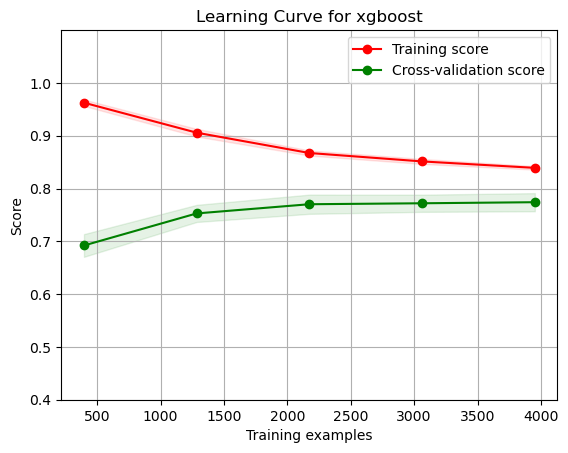

Ended at =  09/05/2024 03:58:45
Total processing time: 0.07 minutes.


In [53]:
# Start time
start_time = time.time()
start_dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("Started at = ", start_dt_string)

#### 
select_and_plot_best_model(approach3_model_metrics, approach3_X_filtered, approach3_y)

# End time
end_time = time.time()
end_dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("Ended at = ", end_dt_string)
print(f"Total processing time: {(end_time - start_time) / 60:.2f} minutes.")

## Ensemble Model

In [54]:

# Define ensemble models
ensemble_models = {
    'stacking': StackingClassifier(
        estimators=[
            ('lr', LogisticRegression(
                penalty='l2', C=0.01, max_iter=1000, solver='liblinear'
            )),
            ('svm', SVC(
                probability=True, C=0.05, kernel='rbf', gamma='scale'
            )),
            ('xgb', XGBClassifier(
                use_label_encoder=False, eval_metric='mlogloss',
                alpha=0.05, reg_lambda=0.05, max_depth=4,
                min_child_weight=5, learning_rate=0.05
            ))
        ],
        final_estimator=LogisticRegression(penalty='l2', C=0.01, max_iter=1000, solver='liblinear')
    ),
    'voting': VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(
                penalty='l2', C=0.01, max_iter=1000, solver='liblinear'
            )),
            ('svm', SVC(
                probability=True, C=0.05, kernel='rbf', gamma='scale'
            )),
            ('xgb', XGBClassifier(
                use_label_encoder=False, eval_metric='mlogloss',
                alpha=0.05, reg_lambda=0.05, max_depth=4,
                min_child_weight=5, learning_rate=0.05
            ))
        ],
        voting='soft'
    )
}

# Utility function to load a model from a file
def load_model(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

# Utility function to evaluate a given model using cross-validation
def evaluate_model(model, X, y, model_name):
    cv = StratifiedKFold(n_splits=5)
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f'{model_name} - Accuracy: {np.mean(scores):.2f} ± {np.std(scores):.2f}')
    return np.mean(scores), scores

# Function to plot and save the learning curve for the given estimator
def plot_learning_curve(estimator, title, X, y, cv):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.savefig(f'{title}.png')
    plt.show()

# Function to evaluate and compare ensemble models (Stacking and Voting)
def ensemble_approach(X, y, ensemble_models):
    # Create directory for saving models
    os.makedirs('models', exist_ok=True)

    for name, model in ensemble_models.items():
        # Fit and evaluate each ensemble model
        model.fit(X, y)
        model_mean_score, model_scores = evaluate_model(model, X, y, f"{name.capitalize()} Model")

        # Save the ensemble model
        model_path = f"models/{name.capitalize()}Model.pkl"
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)

        # Plot learning curve for the ensemble
        plot_learning_curve(model, f"Learning Curve for {name.capitalize()} Model", X, y, StratifiedKFold(n_splits=5))

        # Print classification report for the ensemble
        y_pred = model.predict(X)
        print(f"Classification Report for {name.capitalize()} Model:")
        print(classification_report(y, y_pred))

Started at =  09/05/2024 03:58:45
Stacking Model - Accuracy: 0.78 ± 0.02


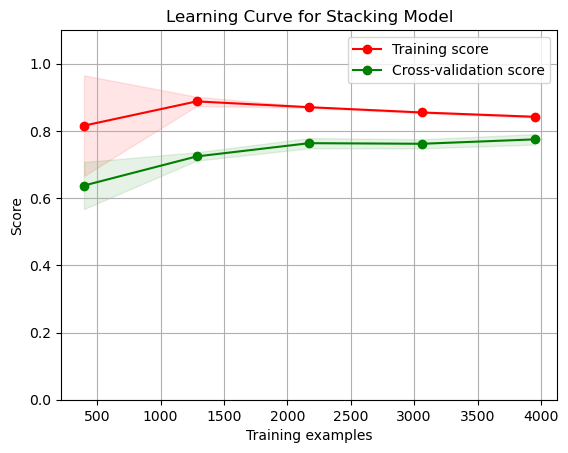

Classification Report for Stacking Model:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      2472
           1       0.82      0.85      0.84      2468

    accuracy                           0.83      4940
   macro avg       0.83      0.83      0.83      4940
weighted avg       0.83      0.83      0.83      4940

Voting Model - Accuracy: 0.73 ± 0.02


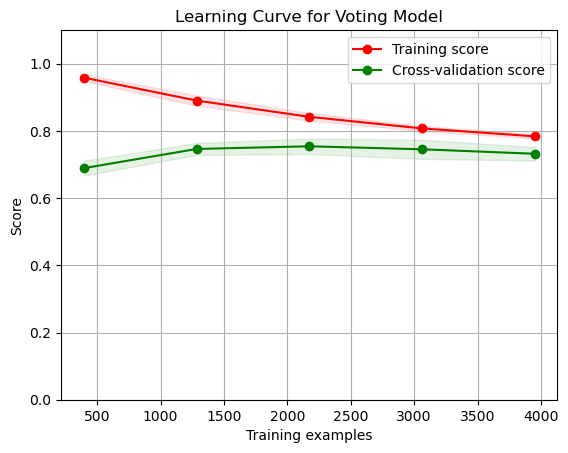

Classification Report for Voting Model:
              precision    recall  f1-score   support

           0       0.77      0.78      0.77      2472
           1       0.77      0.76      0.77      2468

    accuracy                           0.77      4940
   macro avg       0.77      0.77      0.77      4940
weighted avg       0.77      0.77      0.77      4940

Ended at =  09/05/2024 04:12:48
Total processing time: 14.05 minutes.


In [55]:

# Start time
start_time = time.time()
start_dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("Started at = ", start_dt_string)


ensemble_approach(approach3_X_filtered, approach3_y, ensemble_models)

# End time
end_time = time.time()
end_dt_string = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
print("Ended at = ", end_dt_string)
print(f"Total processing time: {(end_time - start_time) / 60:.2f} minutes.")

## Conclusions:

Among the two ensemble methods, Stacking Model and Voting Model, the Stacking Model has shown superior performance for this use case. It achieved a higher cross-validation score (0.77 ± 0.03) compared to the Voting Model (0.73 ± 0.03) and displayed a well-balanced learning curve, indicating a better generalization and less overfitting.

Model Performance:
XGBoost: Achieved an average cross-validation accuracy of 74%.
Ensemble Model: Combining Logistic Regression, SVM, and XGBoost via stacking improved accuracy to 77% (±0.03).

Feature Importance:
SHAP Analysis: Revealed the most influential features include ± max, ± max_opp, pf_total, pf_total_opp, and 3p_total, emphasizing shooting efficiency and offensive production.

In-Season Adaptability:
Rolling Averages: Incorporating rolling averages for key metrics helped the model adapt to in-season changes and capture player/team performance dynamics.

Home-Court Advantage:
Impact on Winning: Home teams showed a higher probability of winning compared to away teams.